# Temperature Prediction

This data is for the purpose of bias correction of next-day maximum and minimum air temperatures forecast of the LDAPS model operated by the Korea Meteorological Administration over Seoul, South Korea. This data consists of summer data from 2013 to 2017. The input data is largely composed of the LDAPS model's next-day forecast data, in-situ maximum and minimum temperatures of present-day, and geographic auxiliary variables. There are two outputs (i.e. next-day maximum and minimum air temperatures) in this data. Hindcast validation was conducted for the period from 2015 to 2017.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold           

import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('temperature_prediction.csv')

In [3]:
df=pd.DataFrame(data=df)

In [4]:
df.head()

station        Date  Present_Tmax  Present_Tmin  LDAPS_RHmin  LDAPS_RHmax  \
0      1.0  30-06-2013          28.7          21.4    58.255688    91.116364   
1      2.0  30-06-2013          31.9          21.6    52.263397    90.604721   
2      3.0  30-06-2013          31.6          23.3    48.690479    83.973587   
3      4.0  30-06-2013          32.0          23.4    58.239788    96.483688   
4      5.0  30-06-2013          31.4          21.9    56.174095    90.155128   

   LDAPS_Tmax_lapse  LDAPS_Tmin_lapse  LDAPS_WS    LDAPS_LH  ...  LDAPS_PPT2  \
0         28.074101         23.006936  6.818887   69.451805  ...         0.0   
1         29.850689         24.035009  5.691890   51.937448  ...         0.0   
2         30.091292         24.565633  6.138224   20.573050  ...         0.0   
3         29.704629         23.326177  5.650050   65.727144  ...         0.0   
4         29.113934         23.486480  5.735004  107.965535  ...         0.0   

   LDAPS_PPT3  LDAPS_PPT4      lat      lon       DEM   Slope  \
0         0.0         0.0  37.6046  126.991  212.3350  2.7850   
1         0.0         0.0  37.6046  127.032   44.7624  0.5141   
2         0.0         0.0  37.5776  127.058   33.3068  0.2661   
3         0.0         0.0  37.6450  127.022   45.7160  2.5348   
4         0.0         0.0  37.5507  127.135   35.0380  0.5055   

   Solar radiation  Next_Tmax  Next_Tmin  
0      5992.895996       29.1       21.2  
1      5869.312500       30.5       22.5  
2      5863.555664       31.1       23.9  
3      5856.964844       31.7       24.3  
4      5859.552246       31.2       22.5  

[5 rows x 25 columns]

In [5]:
df.shape

(7752, 25)

In [6]:
df.dtypes

station             float64
Date                 object
Present_Tmax        float64
Present_Tmin        float64
LDAPS_RHmin         float64
LDAPS_RHmax         float64
LDAPS_Tmax_lapse    float64
LDAPS_Tmin_lapse    float64
LDAPS_WS            float64
LDAPS_LH            float64
LDAPS_CC1           float64
LDAPS_CC2           float64
LDAPS_CC3           float64
LDAPS_CC4           float64
LDAPS_PPT1          float64
LDAPS_PPT2          float64
LDAPS_PPT3          float64
LDAPS_PPT4          float64
lat                 float64
lon                 float64
DEM                 float64
Slope               float64
Solar radiation     float64
Next_Tmax           float64
Next_Tmin           float64
dtype: object

In [7]:
df.apply(lambda x: len(x.unique()))

station               26
Date                 311
Present_Tmax         168
Present_Tmin         156
LDAPS_RHmin         7673
LDAPS_RHmax         7665
LDAPS_Tmax_lapse    7676
LDAPS_Tmin_lapse    7676
LDAPS_WS            7676
LDAPS_LH            7676
LDAPS_CC1           7570
LDAPS_CC2           7583
LDAPS_CC3           7600
LDAPS_CC4           7525
LDAPS_PPT1          2813
LDAPS_PPT2          2511
LDAPS_PPT3          2357
LDAPS_PPT4          1919
lat                   12
lon                   25
DEM                   25
Slope                 27
Solar radiation     1575
Next_Tmax            184
Next_Tmin            158
dtype: int64

In [8]:
df["Day"]=pd.to_datetime(df["Date"]).dt.day
df["Month"]=pd.to_datetime(df["Date"]).dt.month

In [9]:
df.drop('Date',axis=1,inplace=True)

In [10]:
df.describe()

station  Present_Tmax  Present_Tmin  LDAPS_RHmin  LDAPS_RHmax  \
count  7750.000000   7682.000000   7682.000000  7677.000000  7677.000000   
mean     13.000000     29.768211     23.225059    56.759372    88.374804   
std       7.211568      2.969999      2.413961    14.668111     7.192004   
min       1.000000     20.000000     11.300000    19.794666    58.936283   
25%       7.000000     27.800000     21.700000    45.963543    84.222862   
50%      13.000000     29.900000     23.400000    55.039024    89.793480   
75%      19.000000     32.000000     24.900000    67.190056    93.743629   
max      25.000000     37.600000     29.900000    98.524734   100.000153   

       LDAPS_Tmax_lapse  LDAPS_Tmin_lapse     LDAPS_WS     LDAPS_LH  \
count       7677.000000       7677.000000  7677.000000  7677.000000   
mean          29.613447         23.512589     7.097875    62.505019   
std            2.947191          2.345347     2.183836    33.730589   
min           17.624954         14.272646     2.882580   -13.603212   
25%           27.673499         22.089739     5.678705    37.266753   
50%           29.703426         23.760199     6.547470    56.865482   
75%           31.710450         25.152909     8.032276    84.223616   
max           38.542255         29.619342    21.857621   213.414006   

         LDAPS_CC1  ...   LDAPS_PPT4          lat          lon          DEM  \
count  7677.000000  ...  7677.000000  7752.000000  7752.000000  7752.000000   
mean      0.368774  ...     0.269407    37.544722   126.991397    61.867972   
std       0.262458  ...     1.206214     0.050352     0.079435    54.279780   
min       0.000000  ...     0.000000    37.456200   126.826000    12.370000   
25%       0.146654  ...     0.000000    37.510200   126.937000    28.700000   
50%       0.315697  ...     0.000000    37.550700   126.995000    45.716000   
75%       0.575489  ...     0.000041    37.577600   127.042000    59.832400   
max       0.967277  ...    16.655469    37.645000   127.135000   212.335000   

             Slope  Solar radiation    Next_Tmax    Next_Tmin          Day  \
count  7752.000000      7752.000000  7725.000000  7725.000000  7750.000000   
mean      1.257048      5341.502803    30.274887    22.932220    16.370968   
std       1.370444       429.158867     3.128010     2.487613     8.241331   
min       0.098475      4329.520508    17.400000    11.300000     7.000000   
25%       0.271300      4999.018555    28.200000    21.300000     8.000000   
50%       0.618000      5436.345215    30.500000    23.100000    16.000000   
75%       1.767800      5728.316406    32.600000    24.600000    24.000000   
max       5.178230      5992.895996    38.900000    29.800000    31.000000   

             Month  
count  7750.000000  
mean      7.080645  
std       2.238364  
min       1.000000  
25%       7.000000  
50%       7.000000  
75%       8.000000  
max      12.000000  

[8 rows x 26 columns]

In [11]:
#checking the null values 
df.isnull().sum()

station              2
Present_Tmax        70
Present_Tmin        70
LDAPS_RHmin         75
LDAPS_RHmax         75
LDAPS_Tmax_lapse    75
LDAPS_Tmin_lapse    75
LDAPS_WS            75
LDAPS_LH            75
LDAPS_CC1           75
LDAPS_CC2           75
LDAPS_CC3           75
LDAPS_CC4           75
LDAPS_PPT1          75
LDAPS_PPT2          75
LDAPS_PPT3          75
LDAPS_PPT4          75
lat                  0
lon                  0
DEM                  0
Slope                0
Solar radiation      0
Next_Tmax           27
Next_Tmin           27
Day                  2
Month                2
dtype: int64

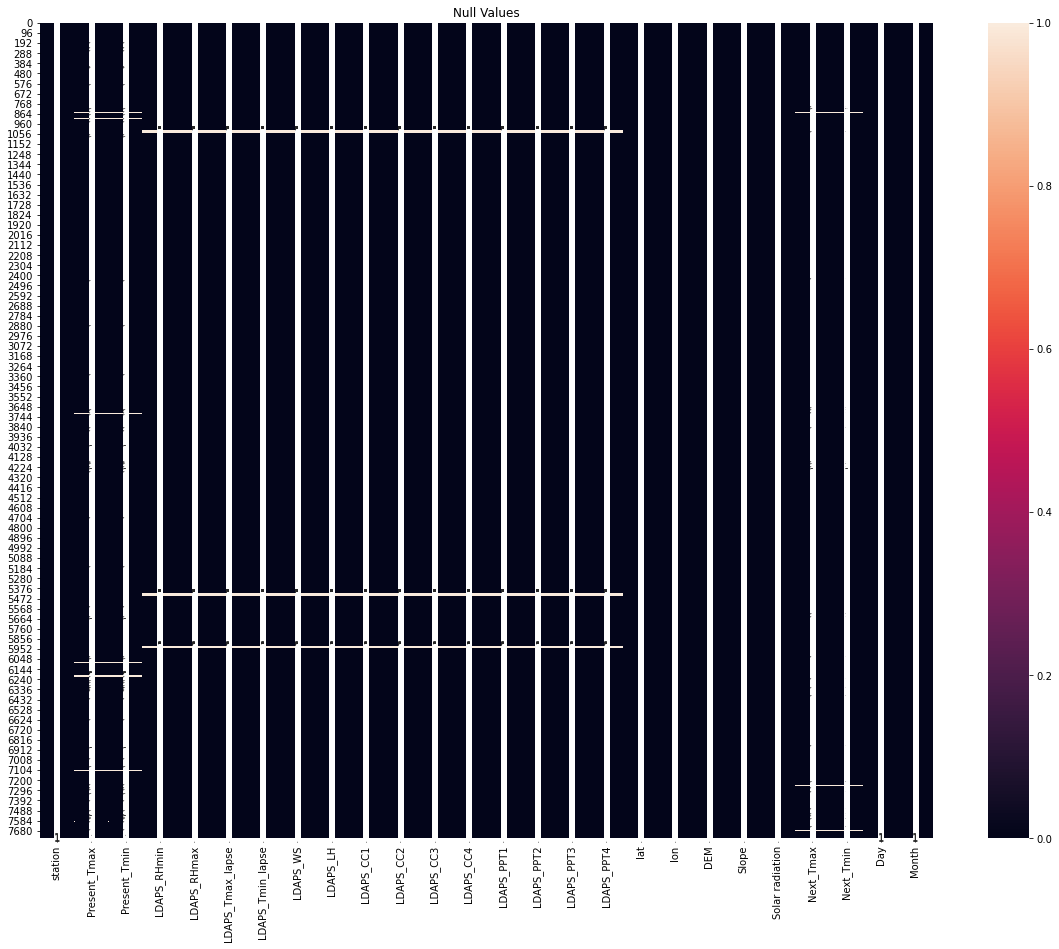

In [12]:
plt.figure(figsize=[20,15])
sns.heatmap(df.isnull(),annot=True)
plt.title('Null Values')
plt.show()

In [13]:
df.loc[df['Next_Tmax'].isnull()]

station  Present_Tmax  Present_Tmin  LDAPS_RHmin  LDAPS_RHmax  \
831       7.0          29.6          25.8    76.202255    94.058517   
856       7.0           NaN           NaN    69.476059    93.672600   
1073     24.0          34.2          25.1    50.618851    89.166397   
2465     16.0          28.8          23.1    71.442566    90.695419   
3696     22.0          30.4          23.4    81.568771    93.973579   
3714     15.0          24.6          22.4    83.265244    94.153442   
3739     15.0           NaN           NaN    68.156593    93.874550   
3886     12.0           NaN           NaN    64.559479    86.083702   
4205      6.0          30.8          23.9    35.218002    82.458534   
4230      6.0           NaN           NaN    43.412582    84.317780   
4255      6.0           NaN           NaN    58.784390    79.509987   
4280      6.0           NaN           NaN    28.475870    89.183807   
5656      7.0          33.1          26.8    64.725151    90.769173   
5681      7.0           NaN           NaN    51.469501    88.160759   
6060     11.0           NaN           NaN    44.908253    86.309982   
6268     19.0          25.6          21.7    84.423805    99.652794   
6357      8.0           NaN           NaN    77.332268    89.395378   
6435     11.0          28.8          24.5    77.014175    90.517715   
6907      8.0          27.5          24.3    54.392185    88.281052   
7254      5.0          30.9          23.3    51.226562    85.210350   
7304      5.0           NaN           NaN    73.782753    85.662842   
7344     20.0          26.2          22.1    85.103630    98.765335   
7504      5.0          27.7          23.3    53.629204    94.092056   
7554      5.0          30.7          23.7    78.330040    91.991310   
7571     22.0          30.2          24.9    76.936493    90.509560   
7604      5.0          30.3          21.7    35.563965    88.866699   
7682      8.0          26.3          18.1    29.959215    90.116638   

      LDAPS_Tmax_lapse  LDAPS_Tmin_lapse   LDAPS_WS    LDAPS_LH  LDAPS_CC1  \
831          28.842727         26.442801   7.980686   87.715882   0.442766   
856          30.491629         25.081388   6.282423  124.191446   0.473034   
1073         33.414349         27.475249   6.084058   48.521008   0.254070   
2465         26.273760         23.419080   3.787889   41.739802   0.260468   
3696         26.724457         24.984435   5.779299   58.456456   0.798225   
3714         26.738321         24.585545   8.048991   43.391457   0.817756   
3739         28.502294         24.270829   5.819343   35.236471   0.863410   
3886         29.628166         25.745189   8.629767   26.564901   0.783111   
4205         32.241880         23.018172   6.547084   63.516243   0.101724   
4230         32.028639         24.274533   5.880758   54.278856   0.140189   
4255         28.628288         24.045805   4.762958   50.826542   0.315319   
4280         33.651696         21.381762   6.050666   61.250346   0.044204   
5656         31.730979         26.316541   5.095636  127.601342   0.066835   
5681         33.531711         27.066962   4.934146  139.353021   0.174230   
6060         26.065732         21.639797   9.656940   78.263273   0.846820   
6268         24.881373         22.821416   9.236040   41.559663   0.898233   
6357         27.467565         24.160557   7.628294   38.808770   0.213881   
6435         28.321989         24.563500  10.349091   53.364445   0.773665   
6907         30.742290         25.195872   6.311136   44.619934   0.483763   
7254         30.742346         23.130362   5.471810  138.030061   0.209946   
7304         25.370156         21.846991   7.367599   72.823796   0.645235   
7344         21.925545         19.703742  14.541317   45.193849   0.472767   
7504         30.448380         24.038216   5.289254  114.941728   0.373159   
7554         28.959303         24.378045  12.264002   76.349382   0.745370   
7571         29.339601         24.659223  11.588554   78.099351   0

In [14]:
df.dropna(subset=['Next_Tmax','Next_Tmin'],inplace=True)

dropping rows with missing values in our target variable columns

In [15]:
df['Month'].fillna(df['Month'].mode()[0],inplace=True)
df['Day'].fillna(df['Day'].mode()[0],inplace=True)

In [16]:
df['Day'].unique()

array([30.,  7., 13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23.,
       24., 25., 26., 27., 28., 29., 31.,  8.])

In [17]:
from sklearn.impute import SimpleImputer

In [18]:
my_imputer=SimpleImputer()
df_new=pd.DataFrame(my_imputer.fit_transform(df))

In [19]:
df_new.columns=df.columns

In [20]:
df_new.isnull().sum()

station             0
Present_Tmax        0
Present_Tmin        0
LDAPS_RHmin         0
LDAPS_RHmax         0
LDAPS_Tmax_lapse    0
LDAPS_Tmin_lapse    0
LDAPS_WS            0
LDAPS_LH            0
LDAPS_CC1           0
LDAPS_CC2           0
LDAPS_CC3           0
LDAPS_CC4           0
LDAPS_PPT1          0
LDAPS_PPT2          0
LDAPS_PPT3          0
LDAPS_PPT4          0
lat                 0
lon                 0
DEM                 0
Slope               0
Solar radiation     0
Next_Tmax           0
Next_Tmin           0
Day                 0
Month               0
dtype: int64

In [21]:
df_new.head()

station  Present_Tmax  Present_Tmin  LDAPS_RHmin  LDAPS_RHmax  \
0      1.0          28.7          21.4    58.255688    91.116364   
1      2.0          31.9          21.6    52.263397    90.604721   
2      3.0          31.6          23.3    48.690479    83.973587   
3      4.0          32.0          23.4    58.239788    96.483688   
4      5.0          31.4          21.9    56.174095    90.155128   

   LDAPS_Tmax_lapse  LDAPS_Tmin_lapse  LDAPS_WS    LDAPS_LH  LDAPS_CC1  ...  \
0         28.074101         23.006936  6.818887   69.451805   0.233947  ...   
1         29.850689         24.035009  5.691890   51.937448   0.225508  ...   
2         30.091292         24.565633  6.138224   20.573050   0.209344  ...   
3         29.704629         23.326177  5.650050   65.727144   0.216372  ...   
4         29.113934         23.486480  5.735004  107.965535   0.151407  ...   

   LDAPS_PPT4      lat      lon       DEM   Slope  Solar radiation  Next_Tmax  \
0         0.0  37.6046  126.991  212.3350  2.7850      5992.895996       29.1   
1         0.0  37.6046  127.032   44.7624  0.5141      5869.312500       30.5   
2         0.0  37.5776  127.058   33.3068  0.2661      5863.555664       31.1   
3         0.0  37.6450  127.022   45.7160  2.5348      5856.964844       31.7   
4         0.0  37.5507  127.135   35.0380  0.5055      5859.552246       31.2   

   Next_Tmin   Day  Month  
0       21.2  30.0    6.0  
1       22.5  30.0    6.0  
2       23.9  30.0    6.0  
3       24.3  30.0    6.0  
4       22.5  30.0    6.0  

[5 rows x 26 columns]

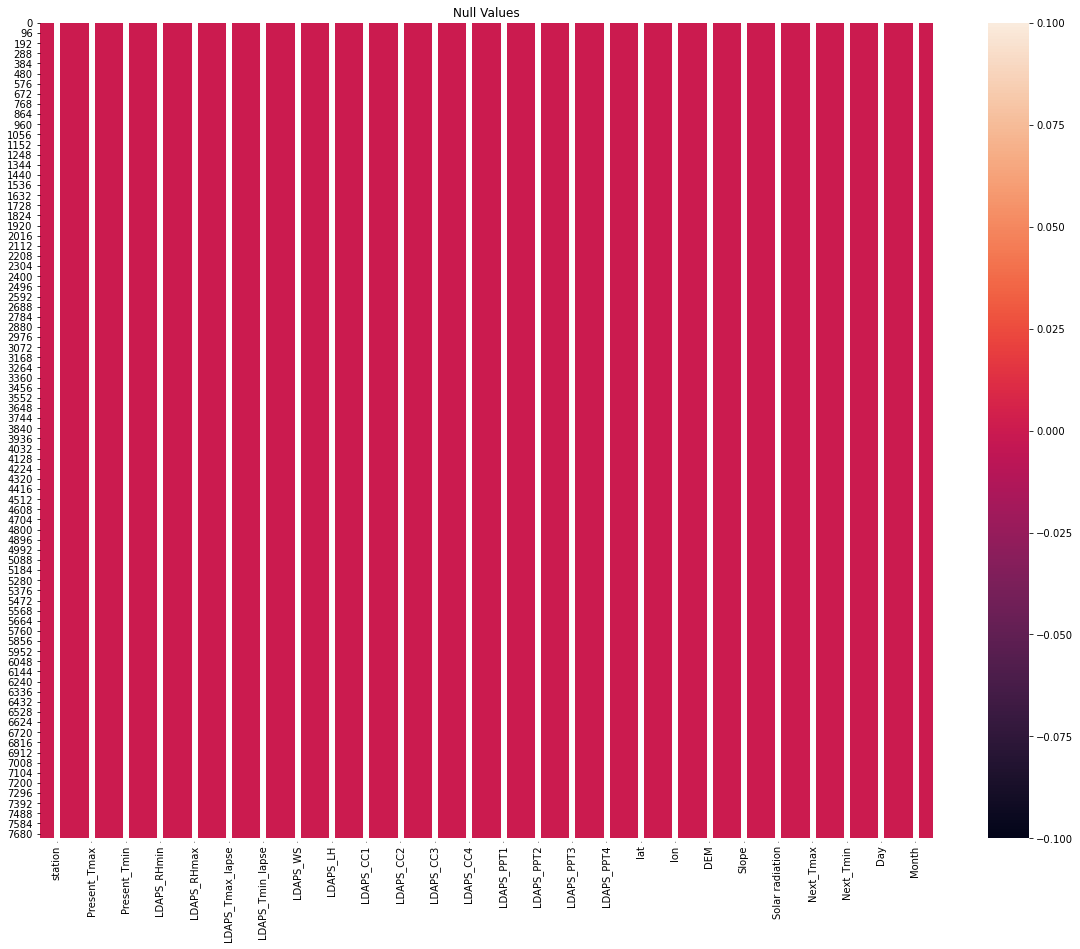

In [22]:
plt.figure(figsize=[20,15])
sns.heatmap(df_new.isnull(),annot=True)
plt.title('Null Values')
plt.show()

# Data Visualisation

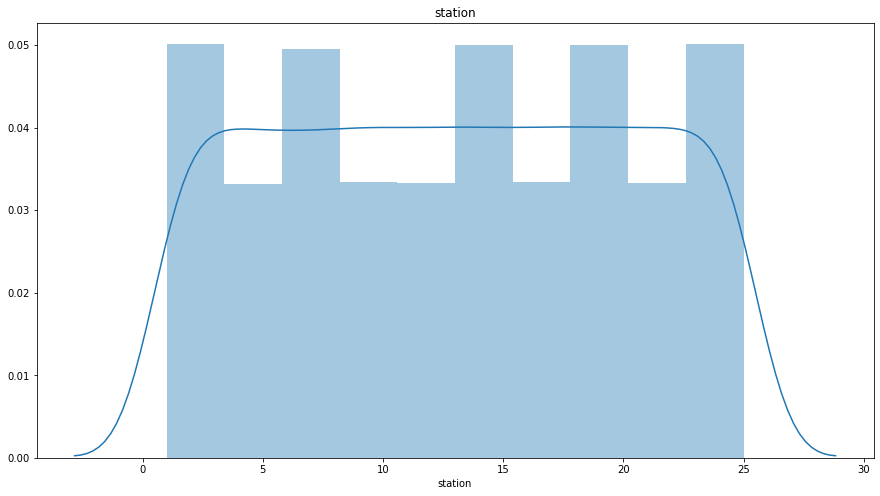

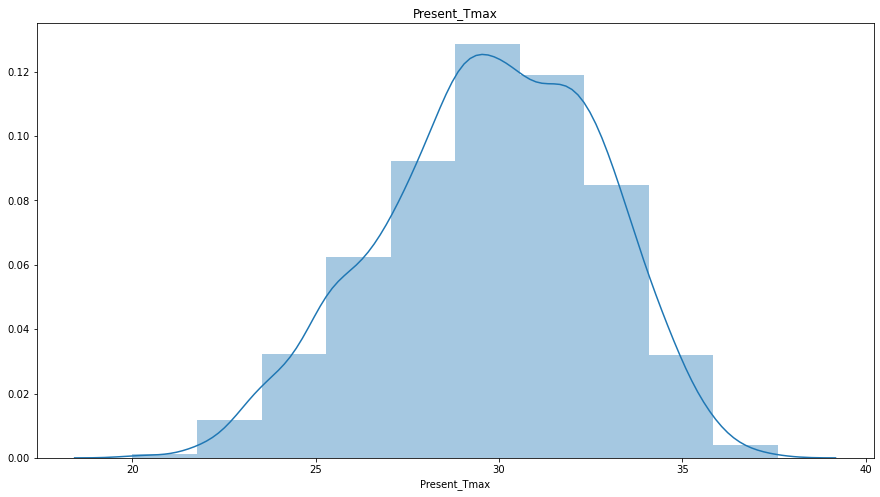

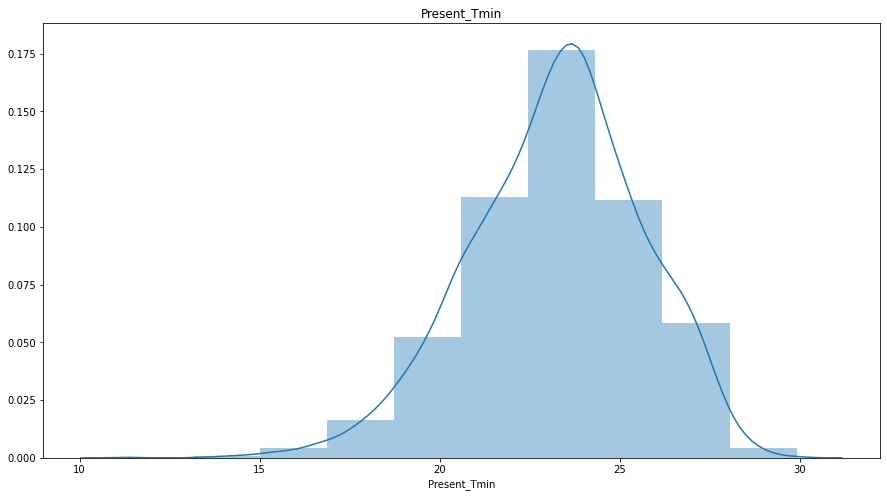

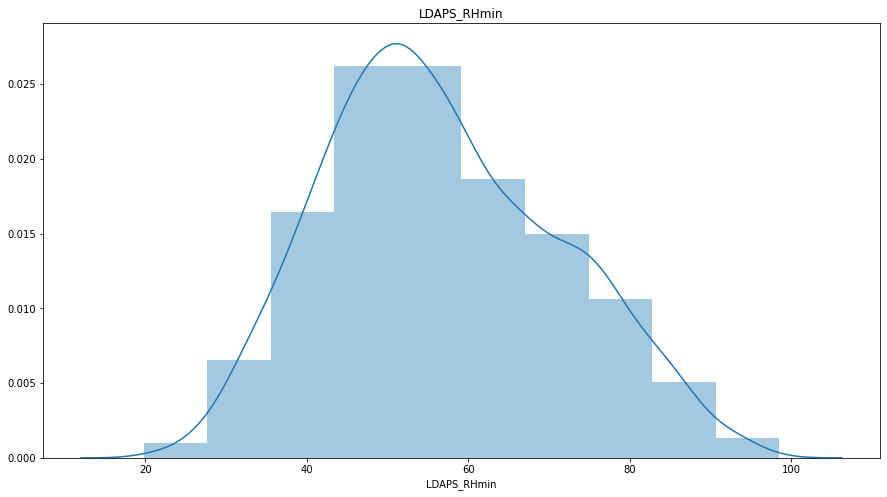

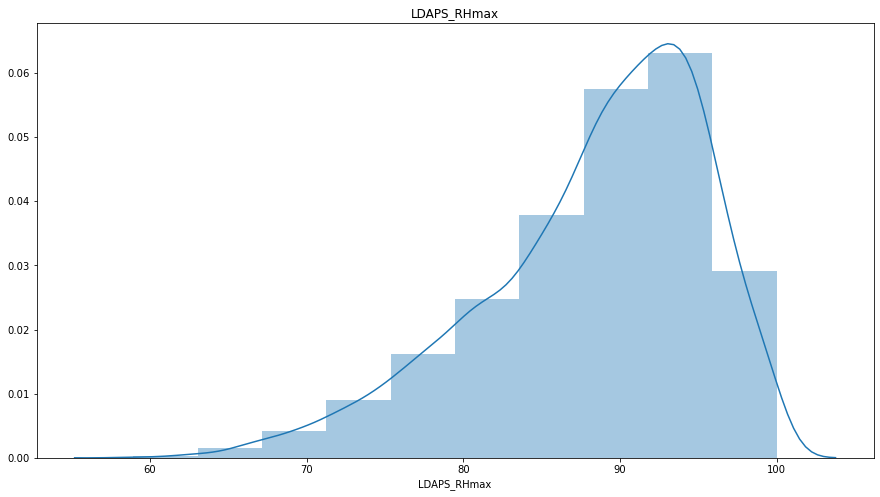

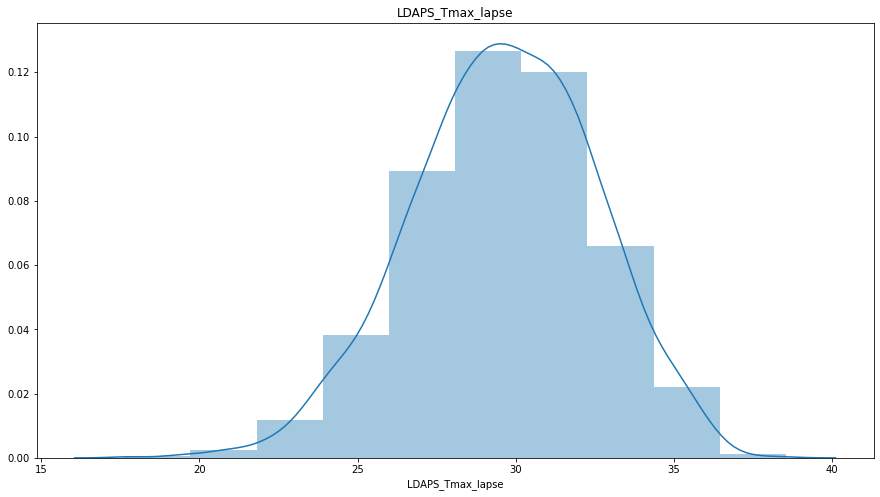

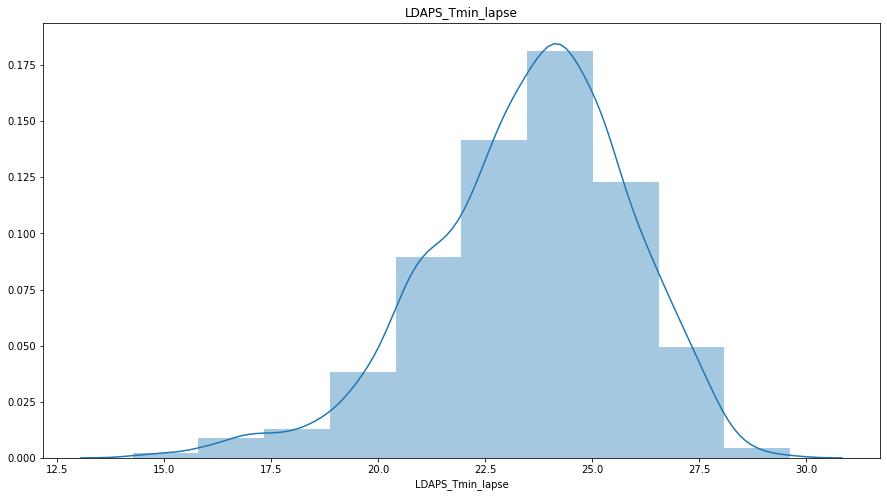

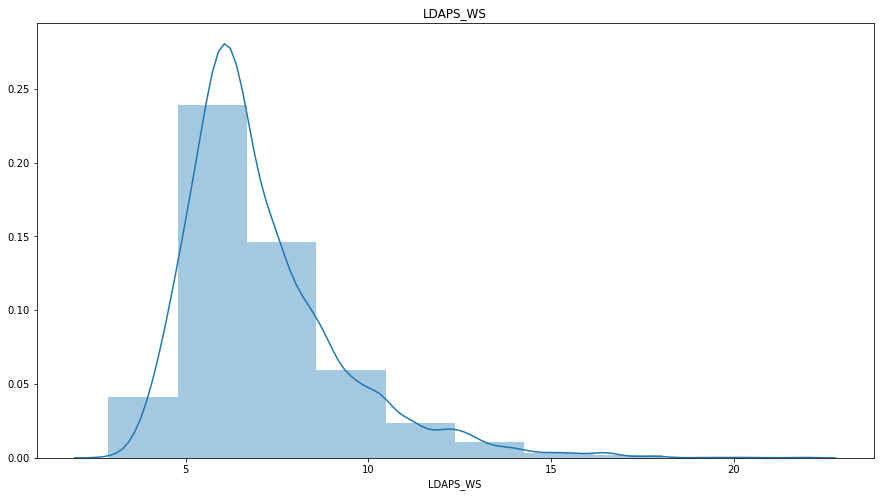

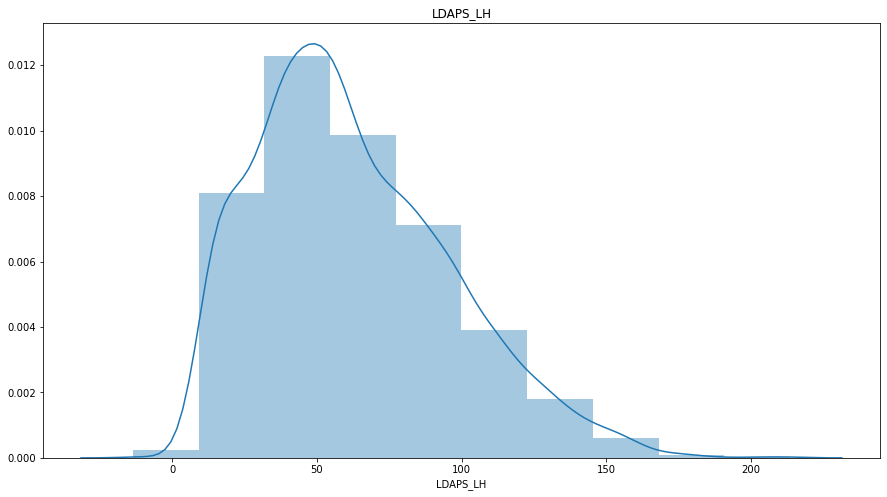

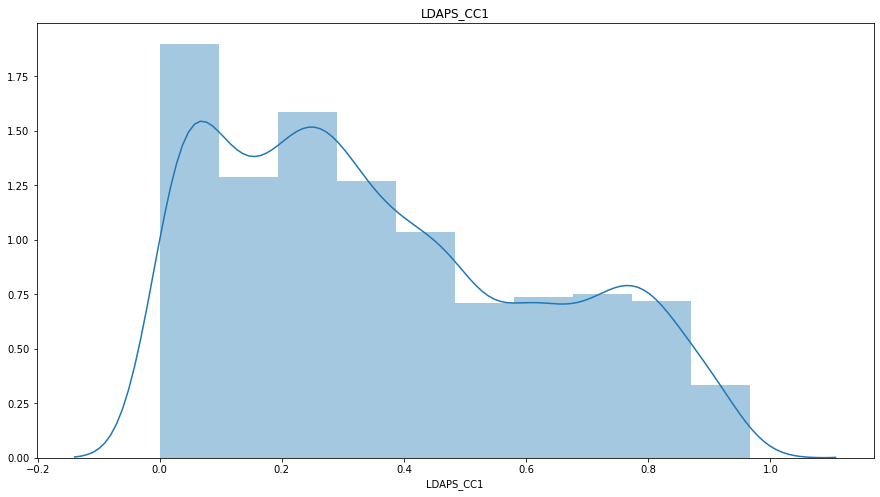

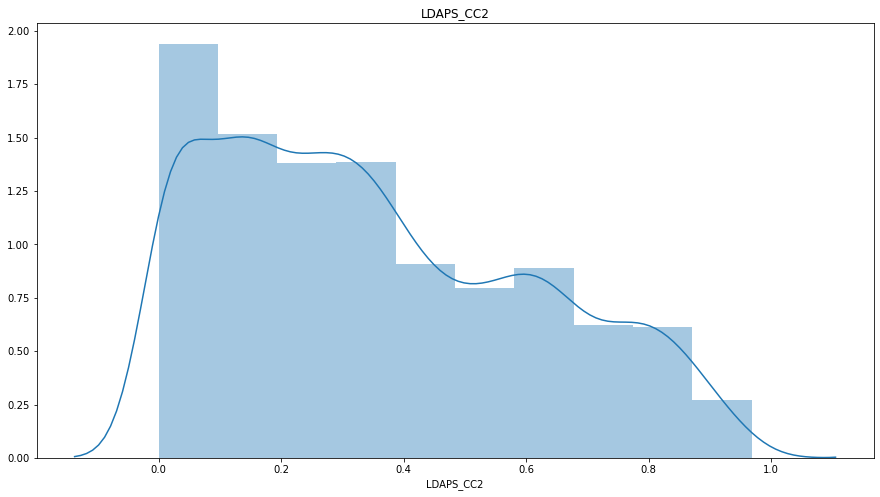

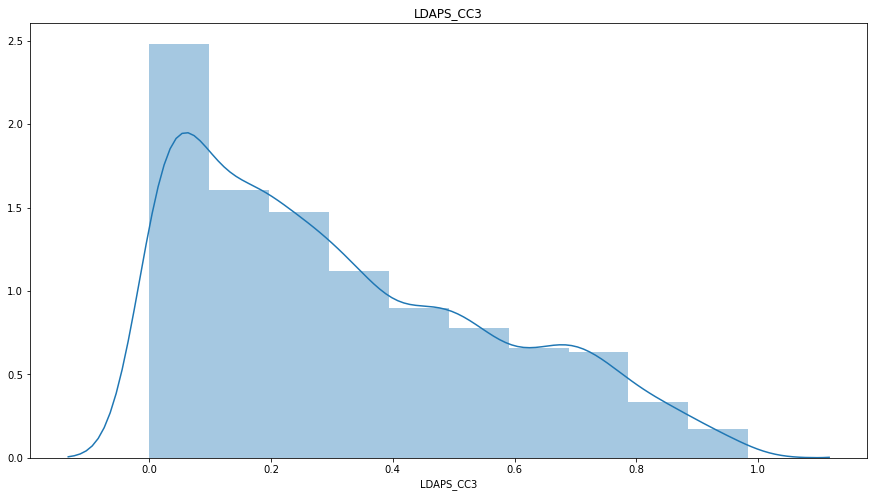

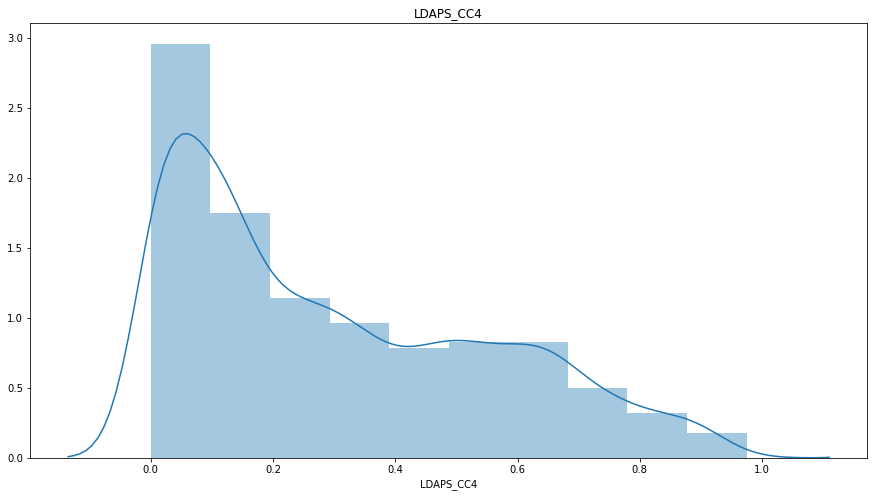

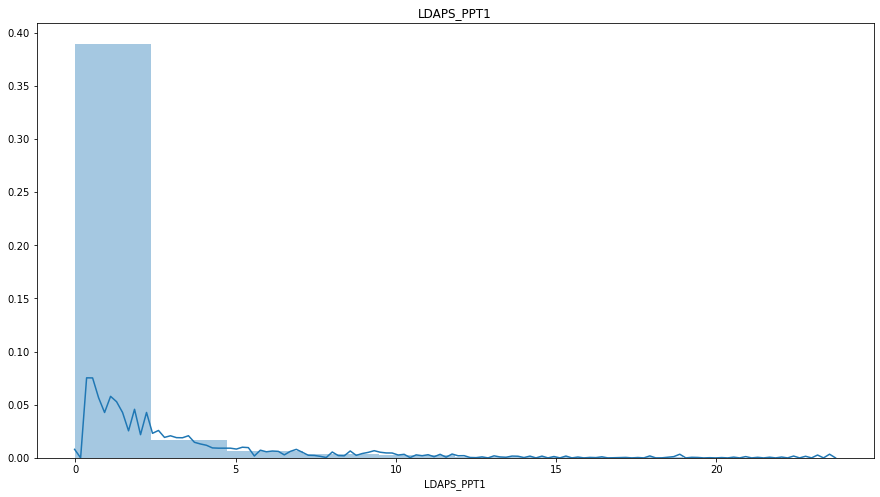

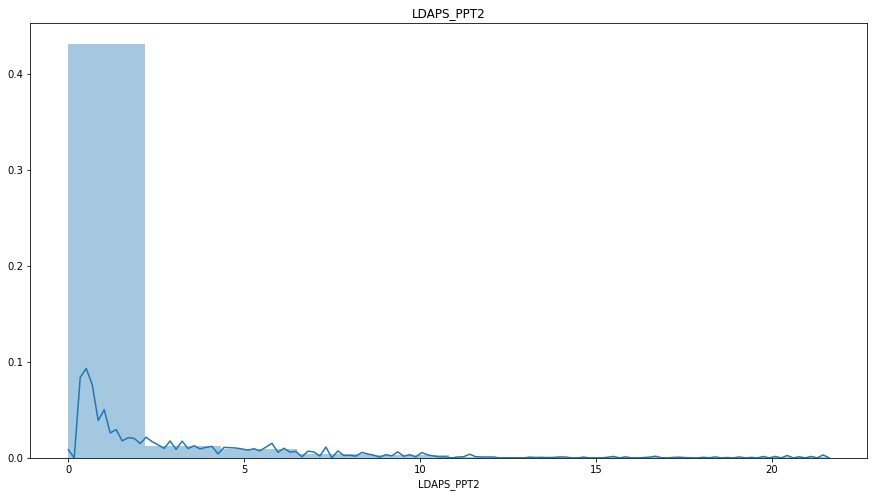

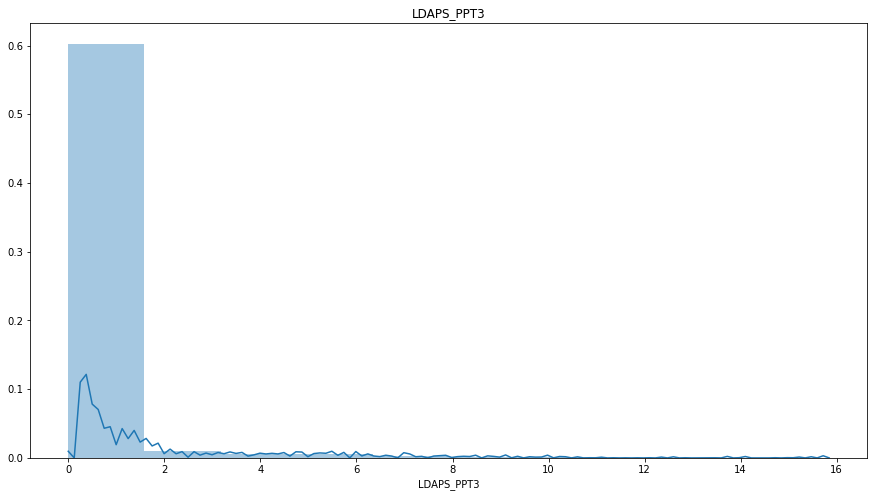

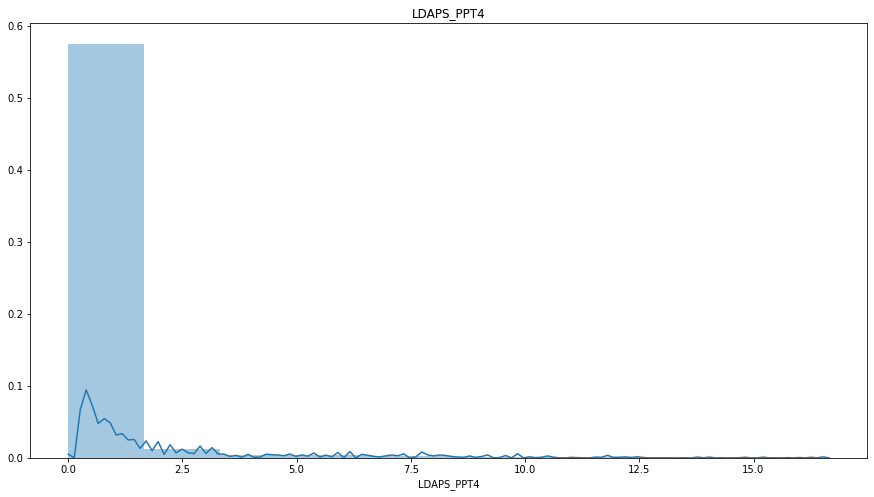

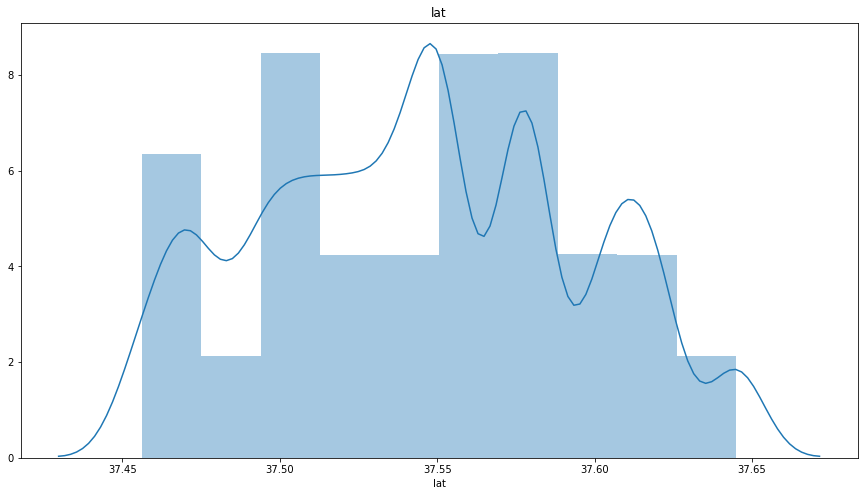

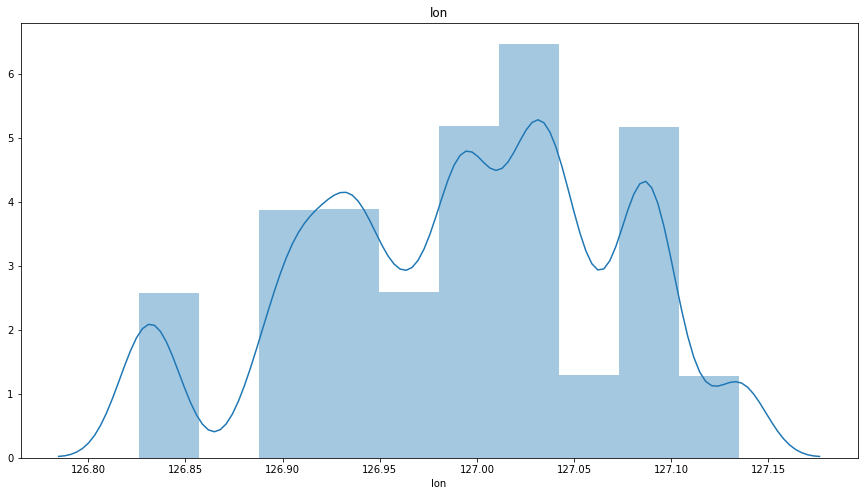

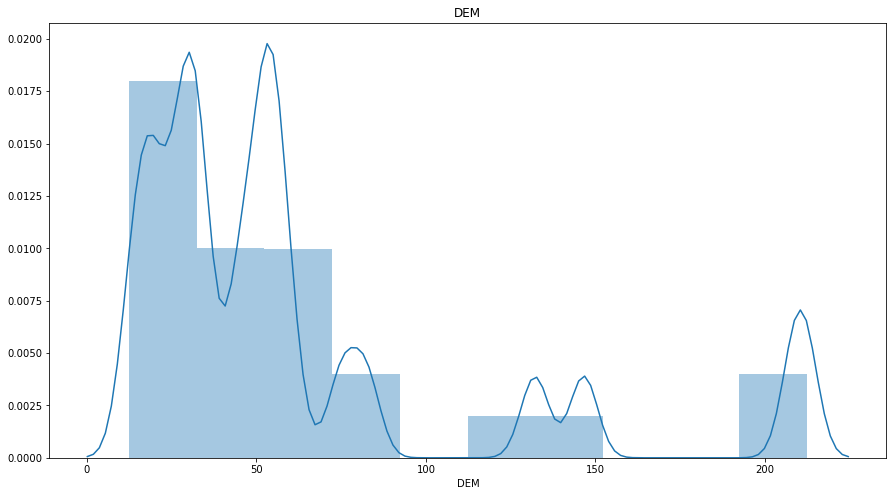

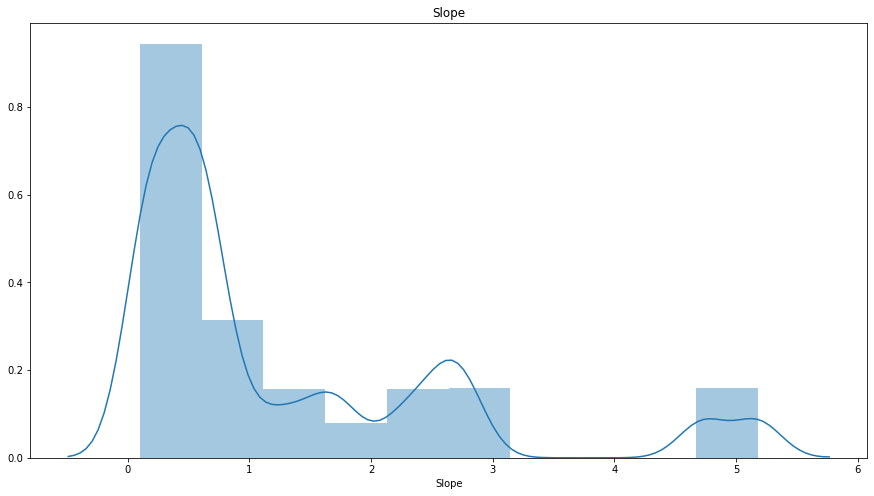

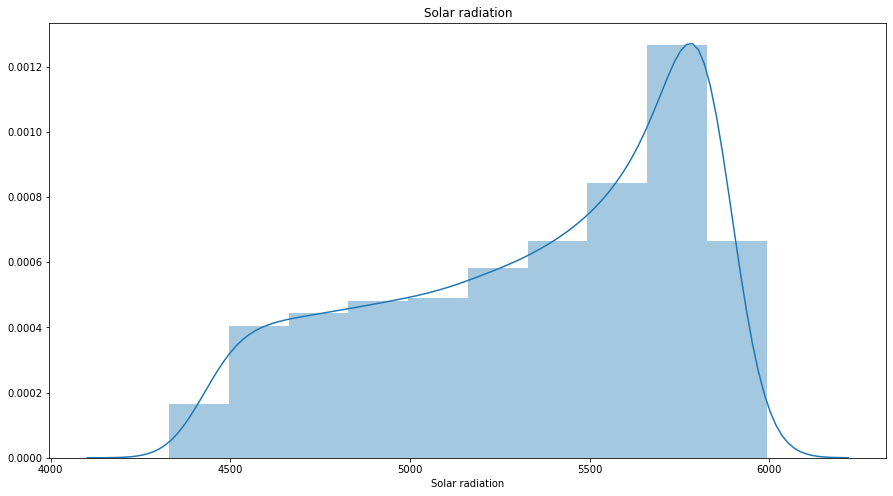

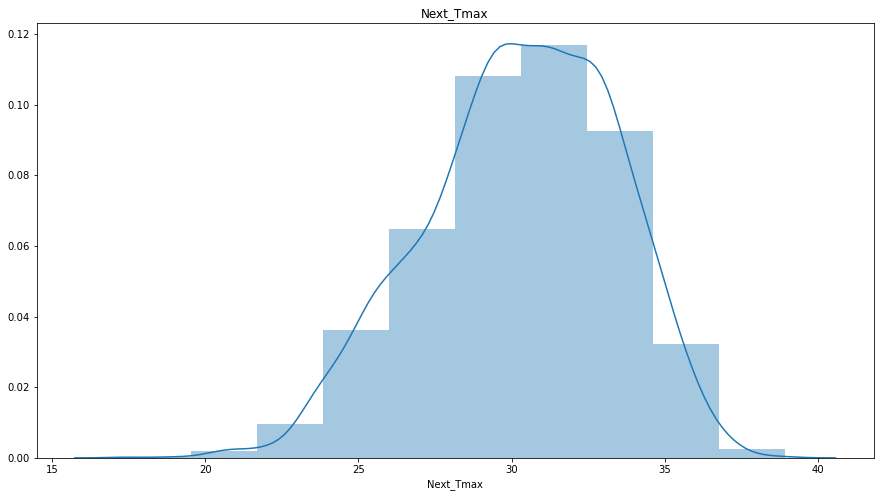

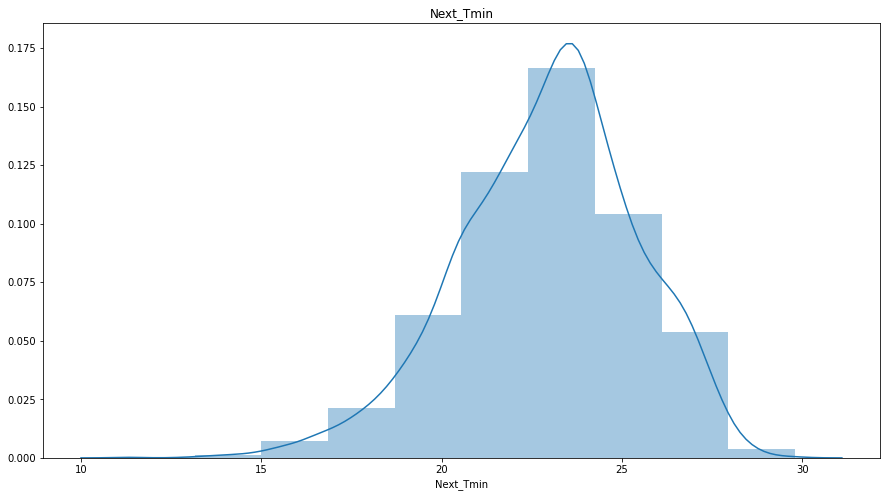

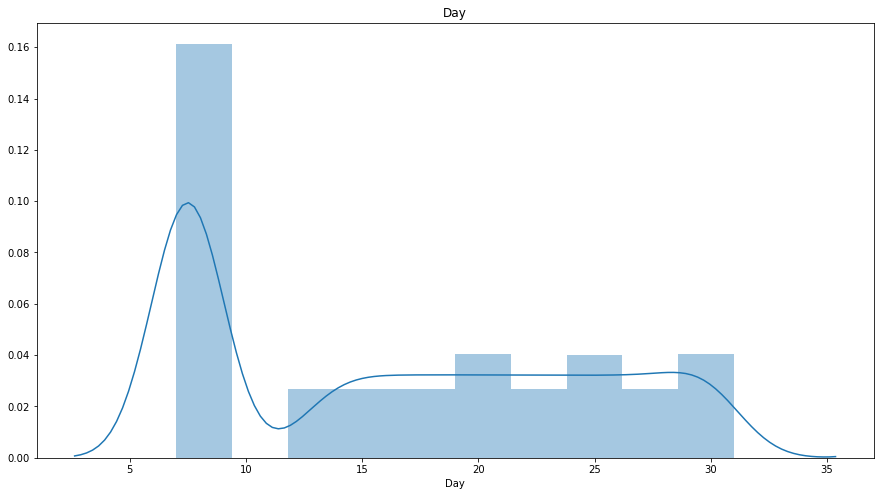

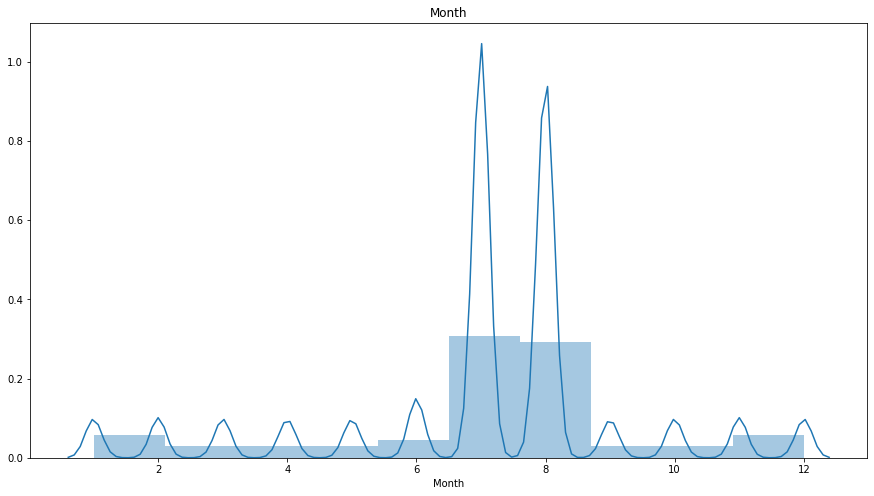

In [23]:
for i in df_new.columns:
    plt.figure(figsize=(15,8))
    sns.distplot(df[i],bins=10)
    plt.title(i)
    plt.show()

Present_Tmax, Present_Tmin, LDAPS_RHmin, LDAPS_Tmax_lapse, LDAPS_Tmin_lapse, Next_Tmax, Next_Tmin all have bell shaped curve graphs.



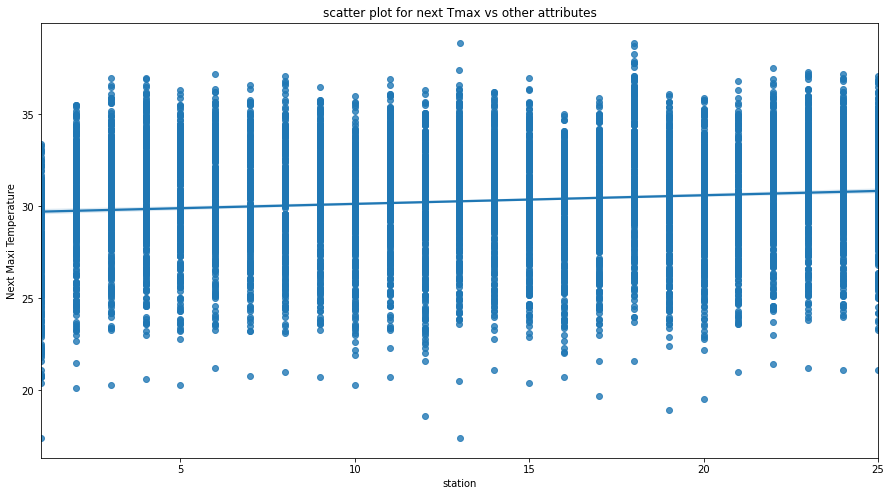

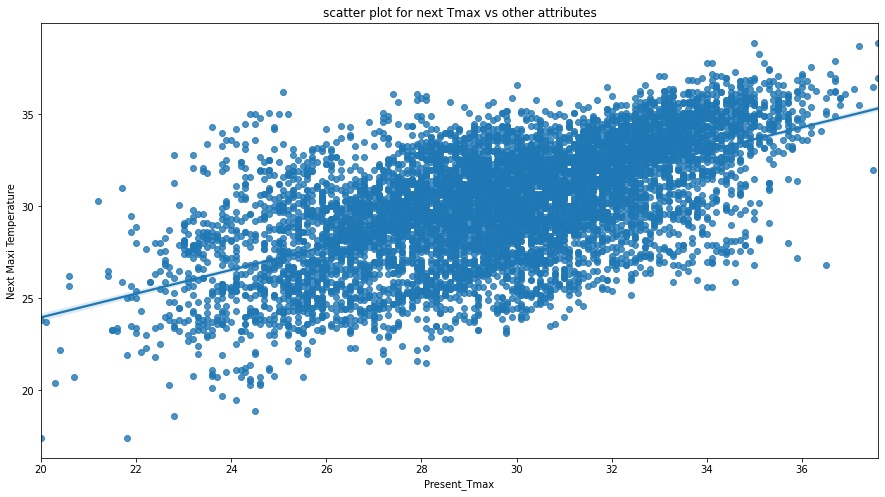

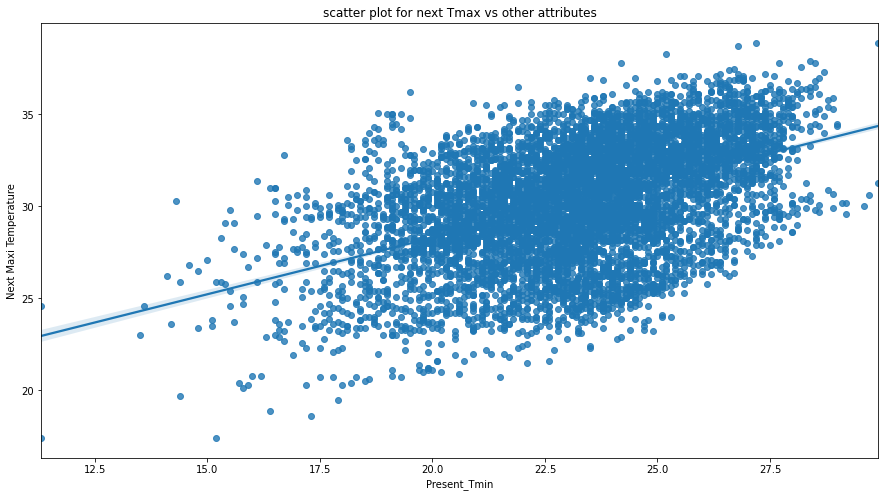

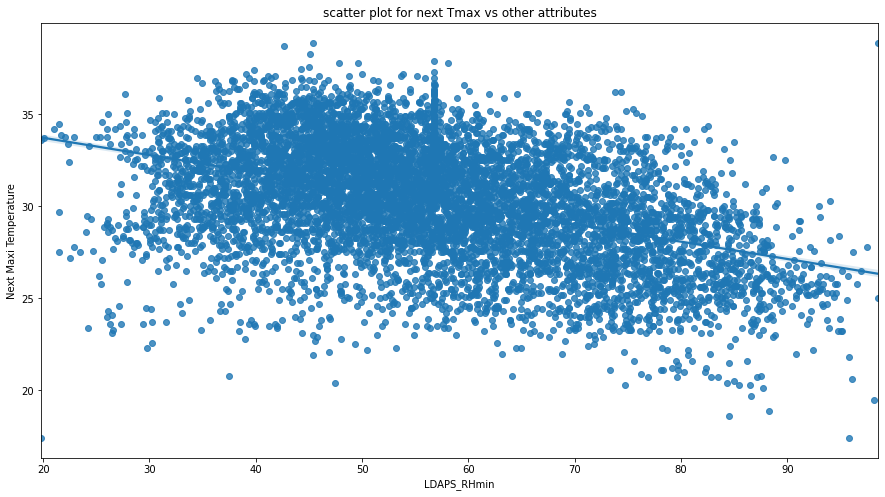

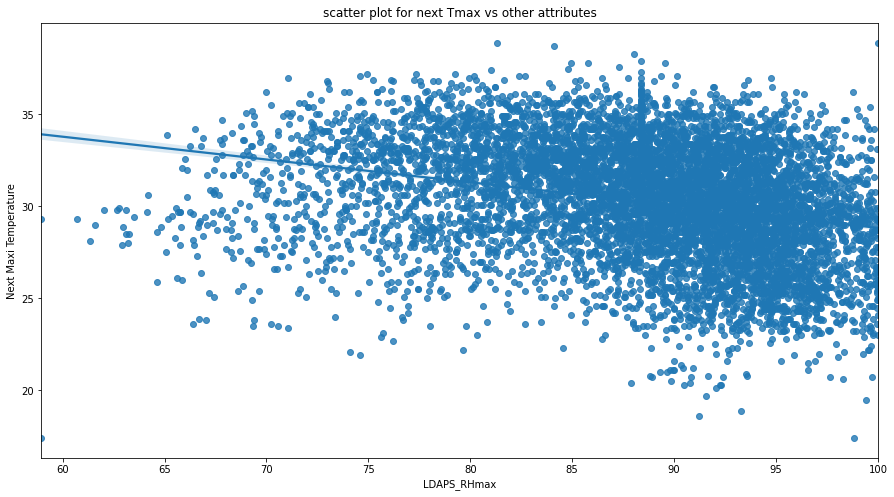

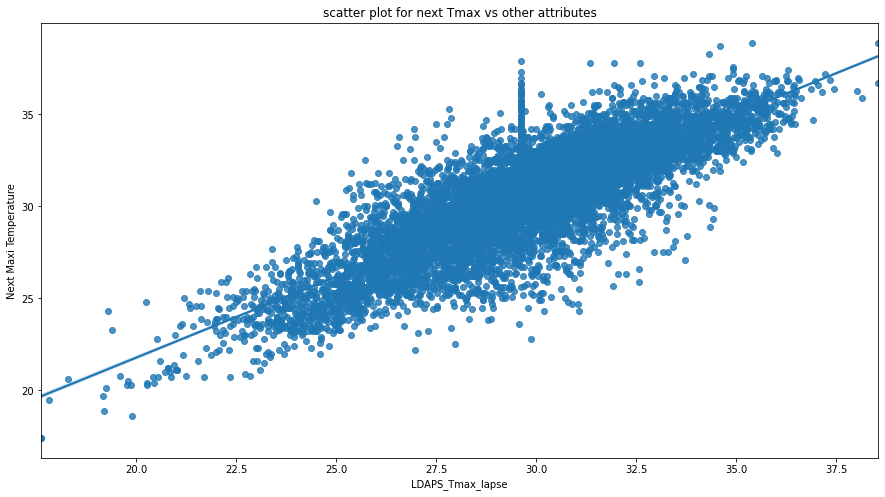

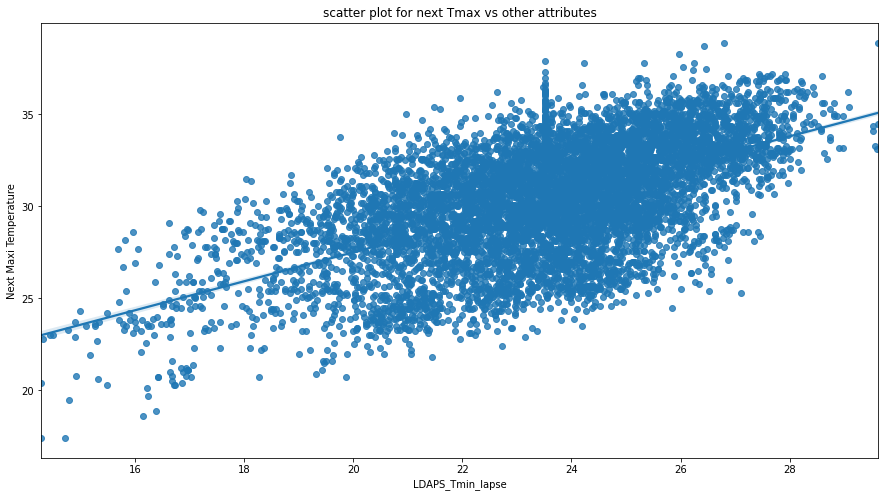

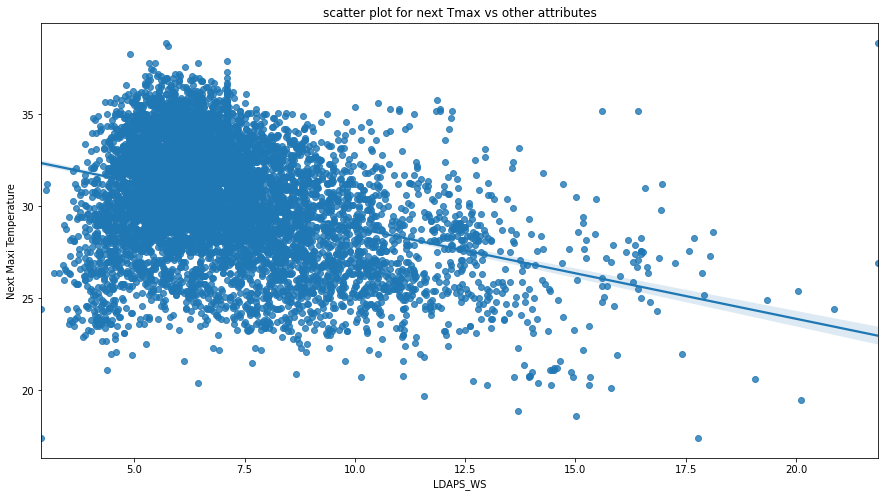

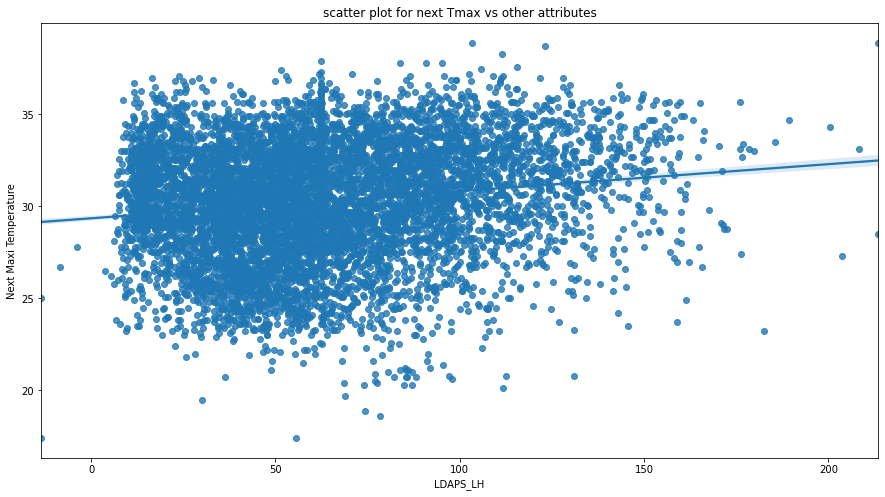

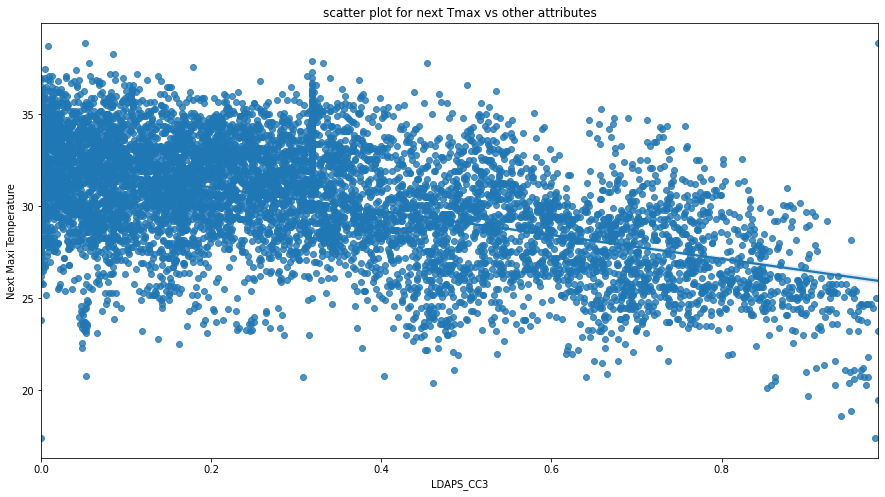

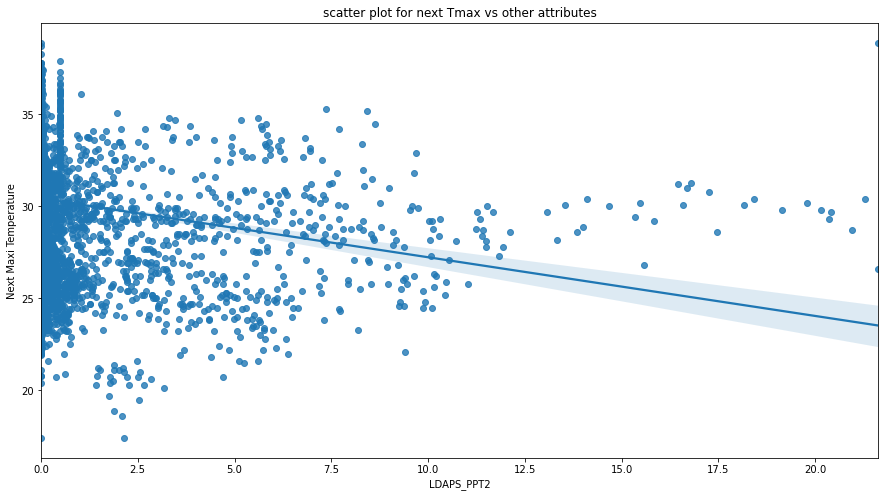

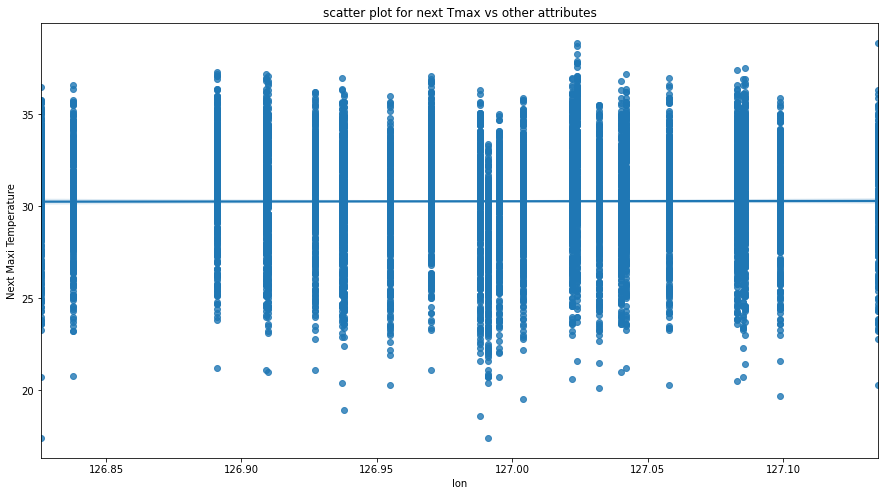

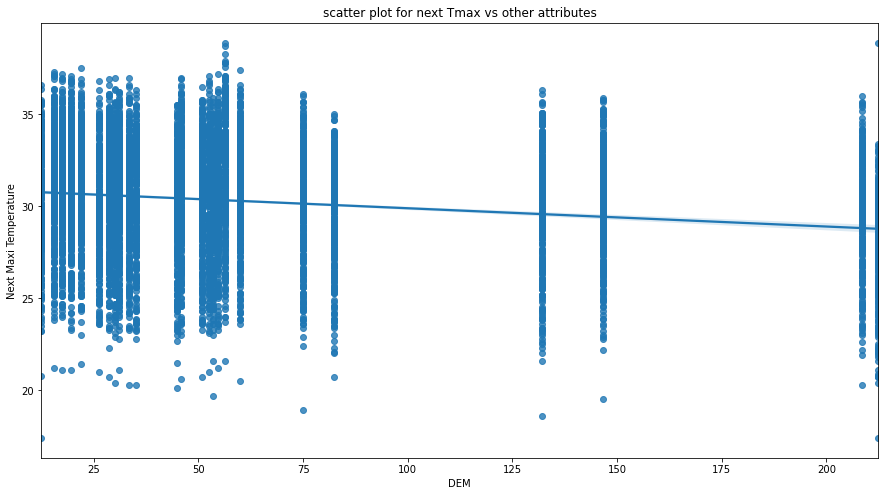

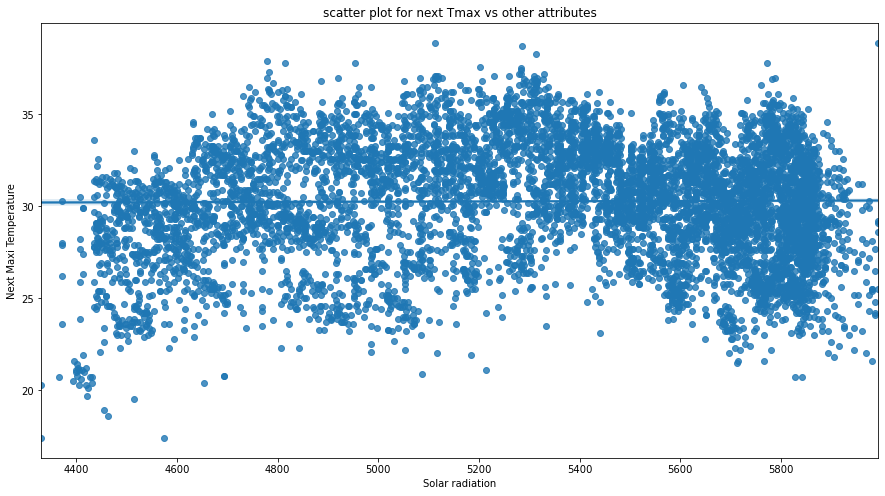

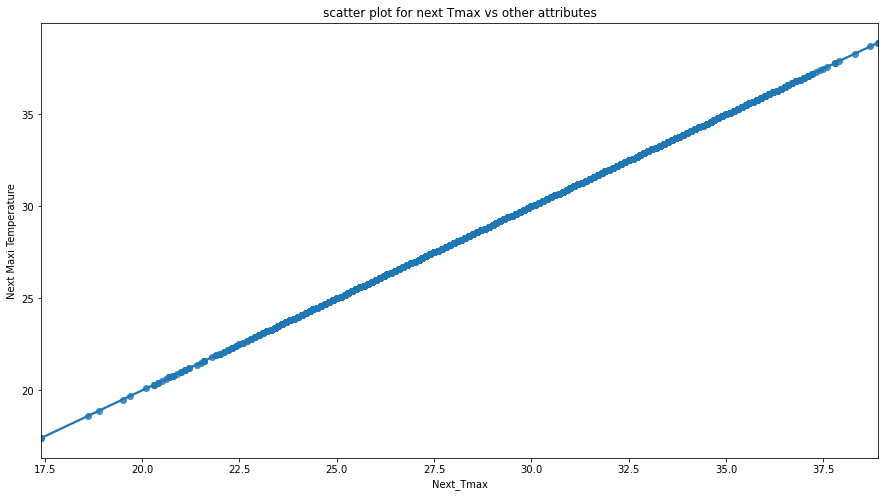

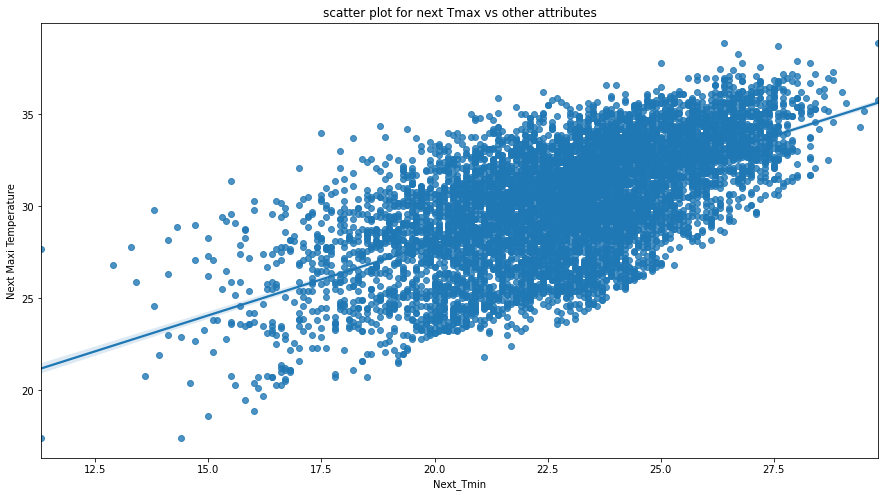

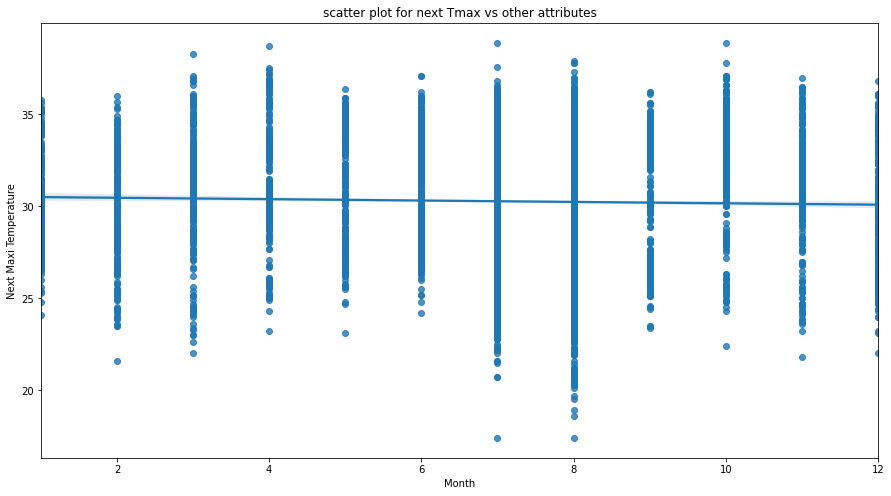

In [24]:
for i in df_new.columns:
    plt.figure(figsize=(15,8))
    sns.regplot(df_new[i],df_new['Next_Tmax'])
    plt.title('scatter plot for next Tmax vs other attributes')
    plt.xlabel(i)
    plt.ylabel('Next Maxi Temperature')
    plt.show()

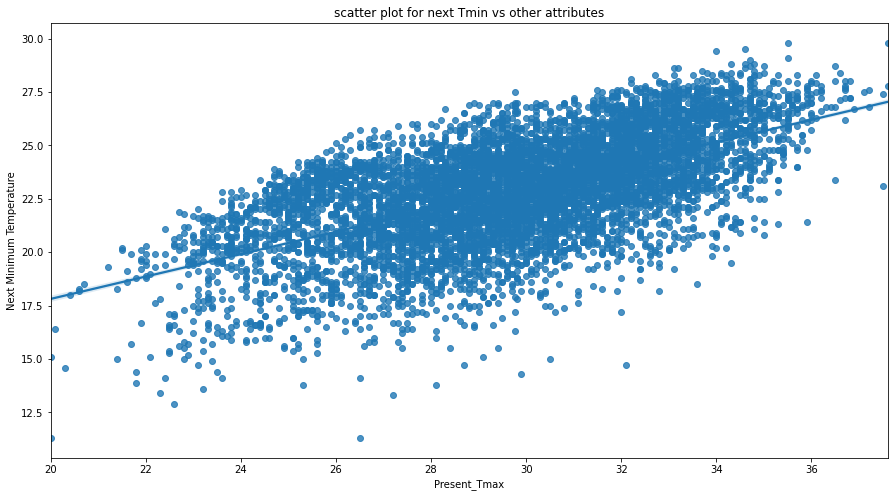

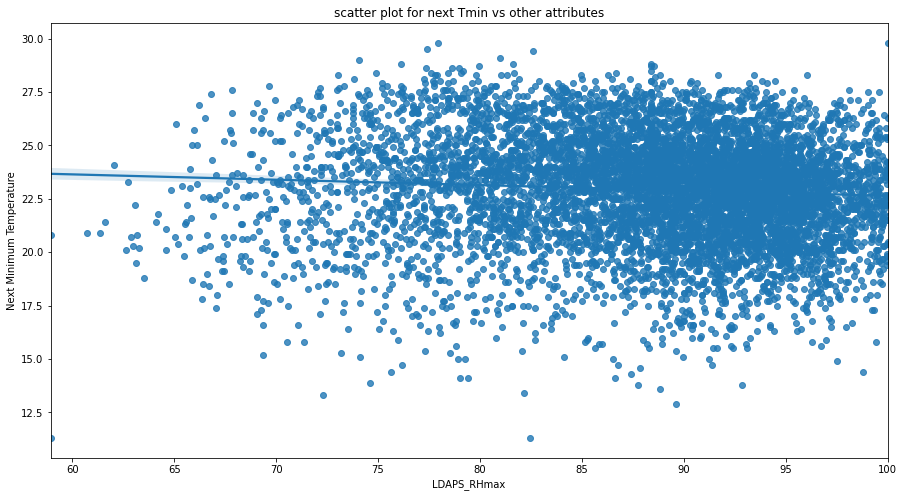

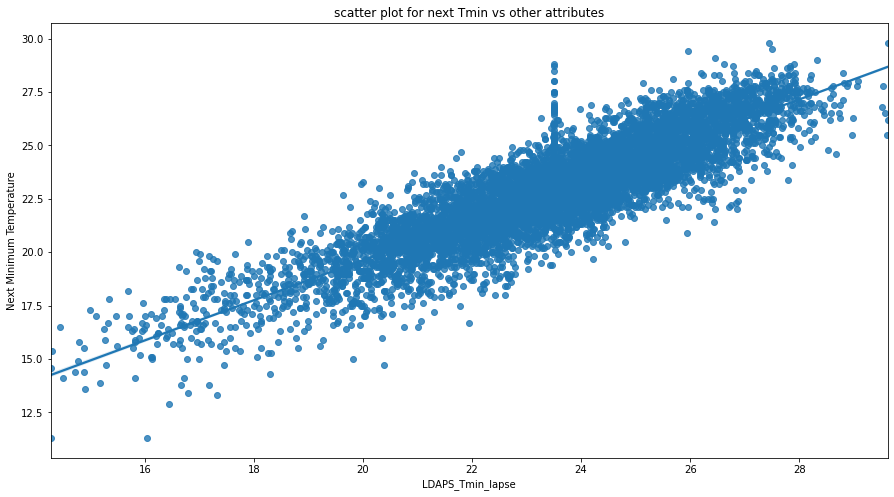

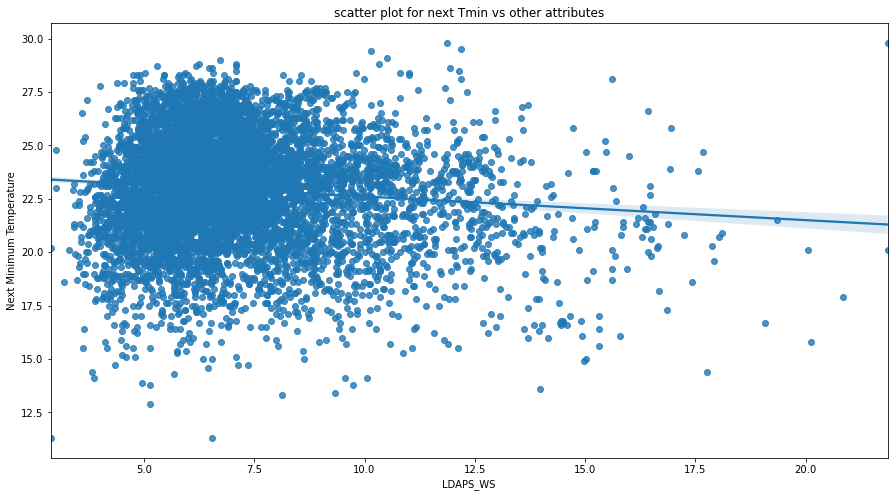

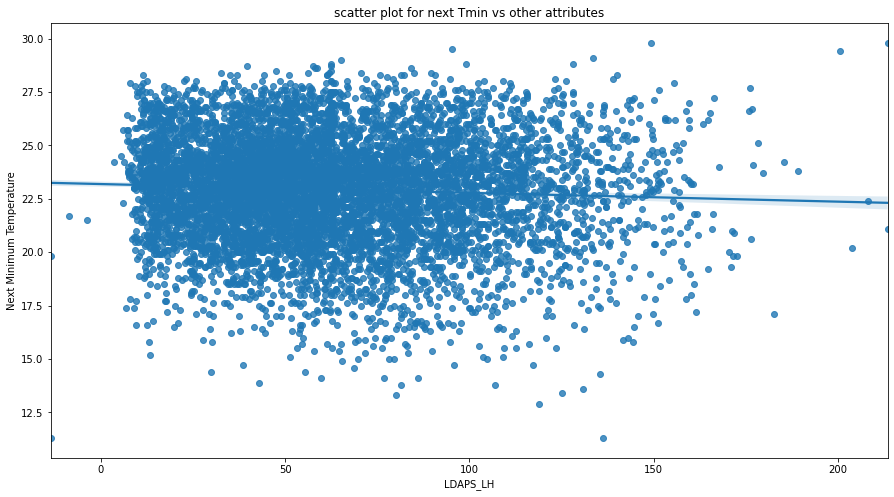

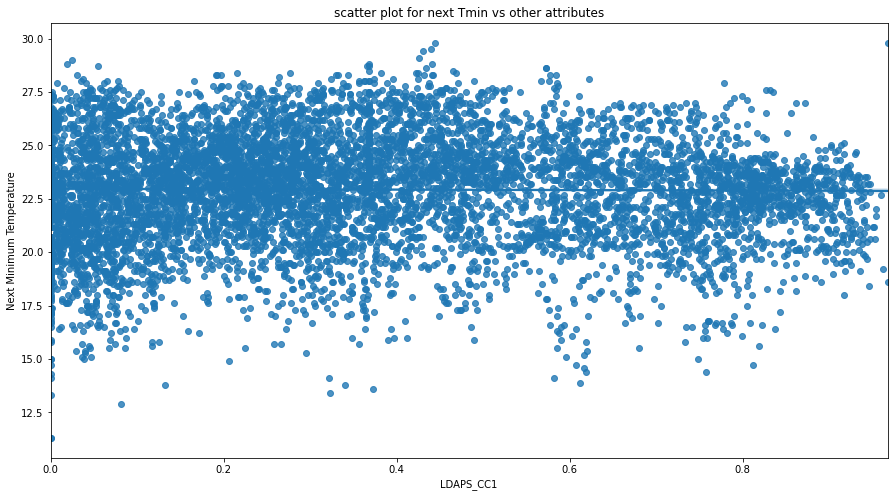

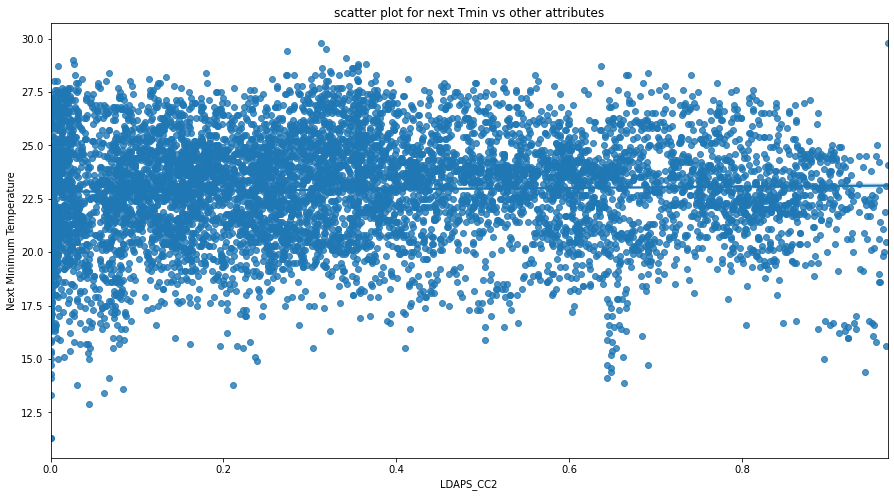

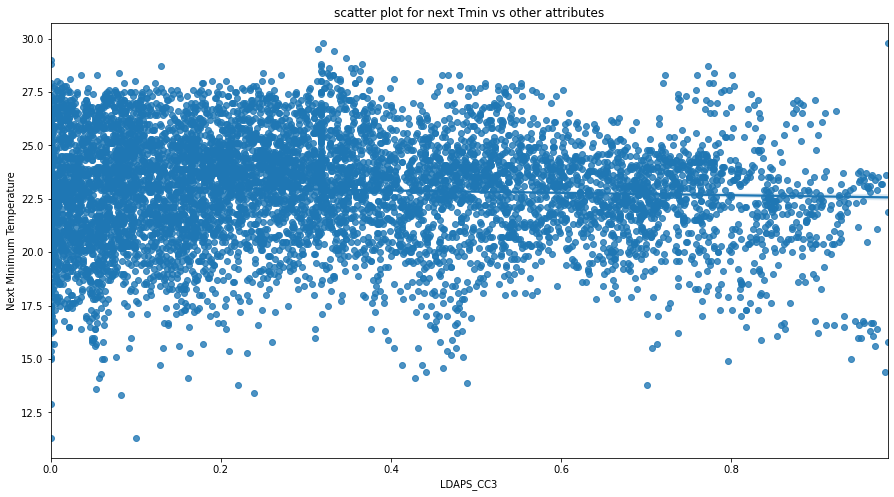

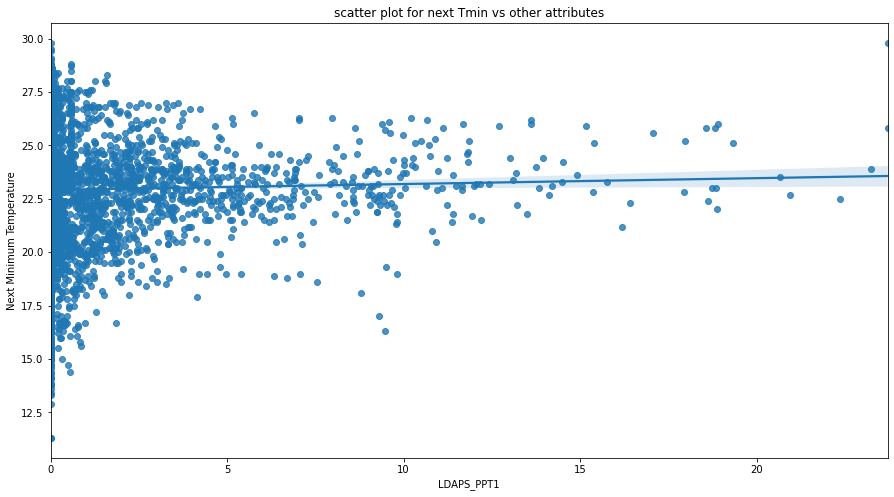

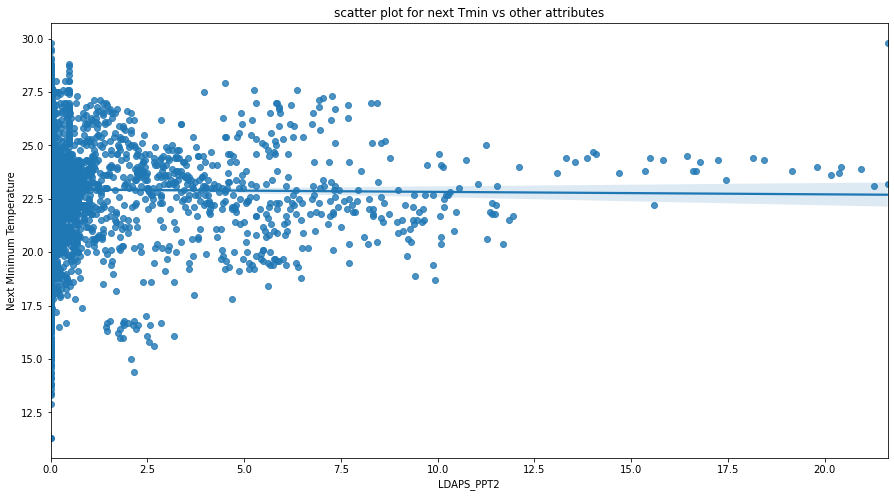

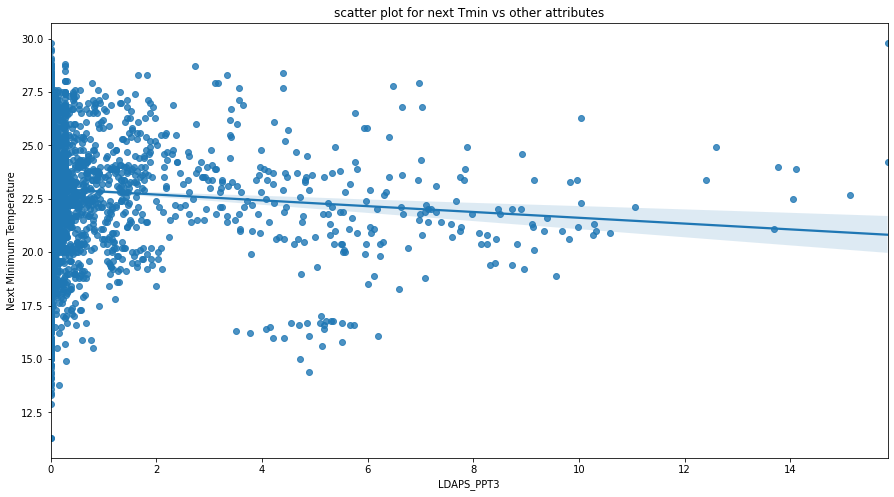

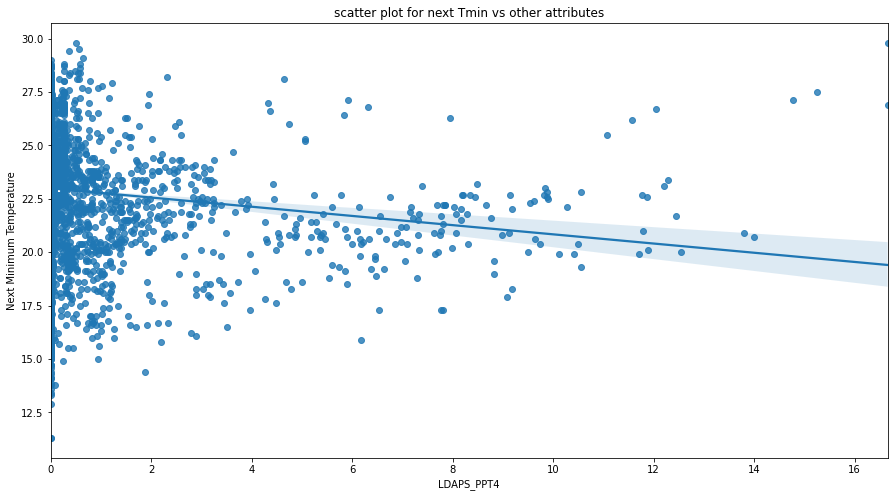

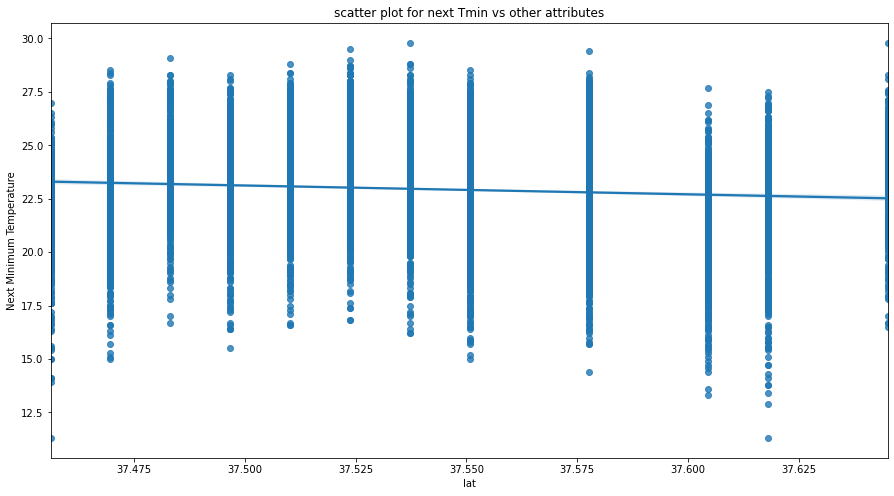

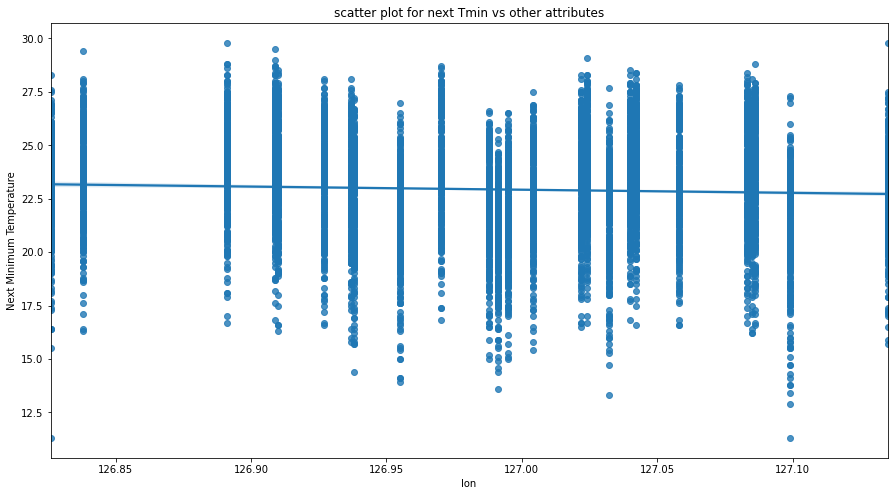

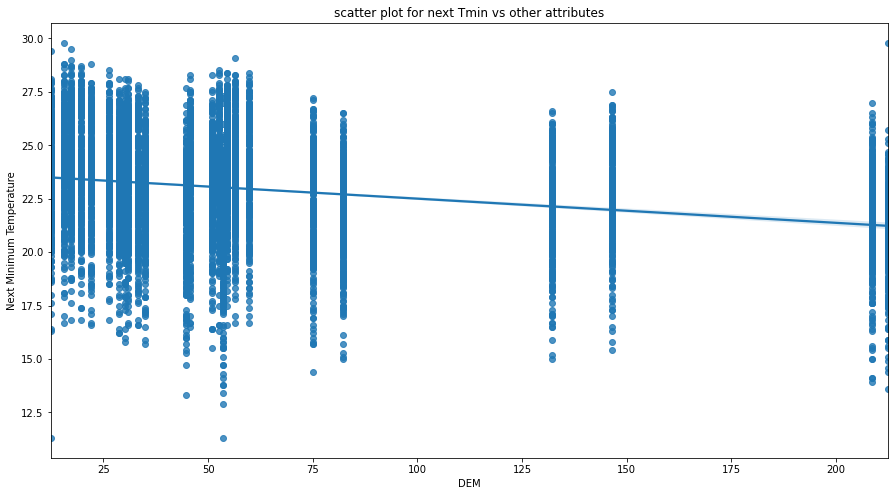

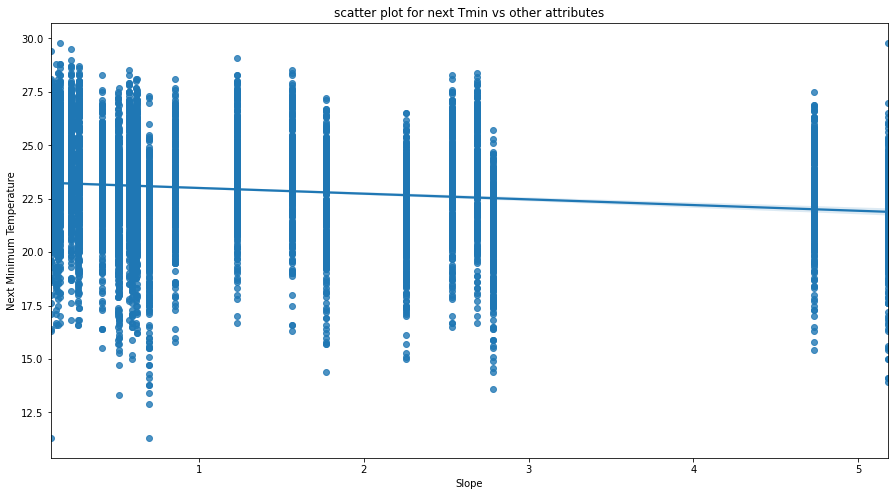

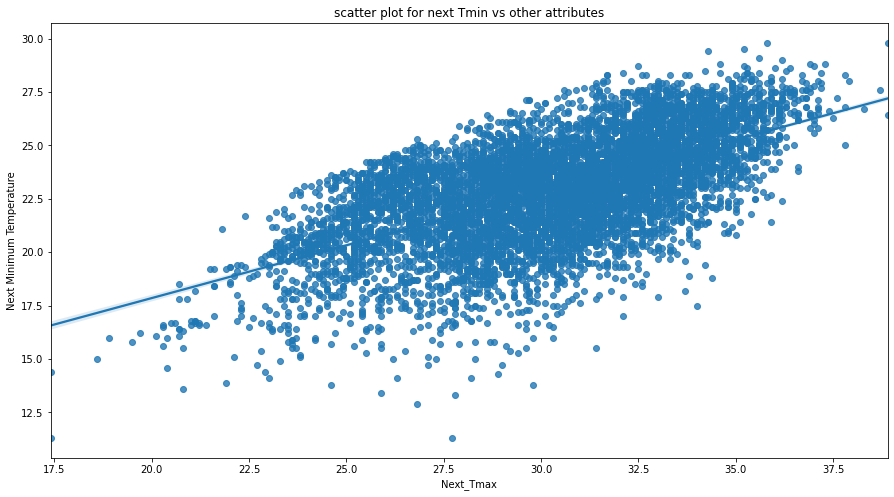

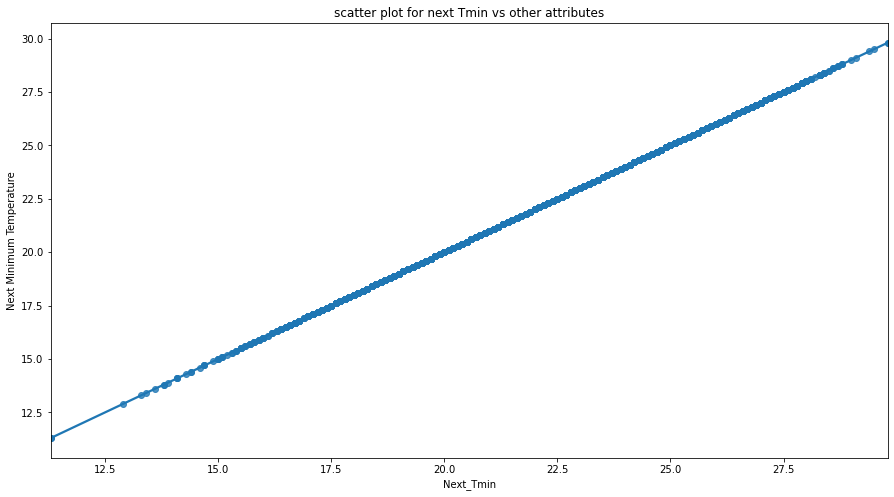

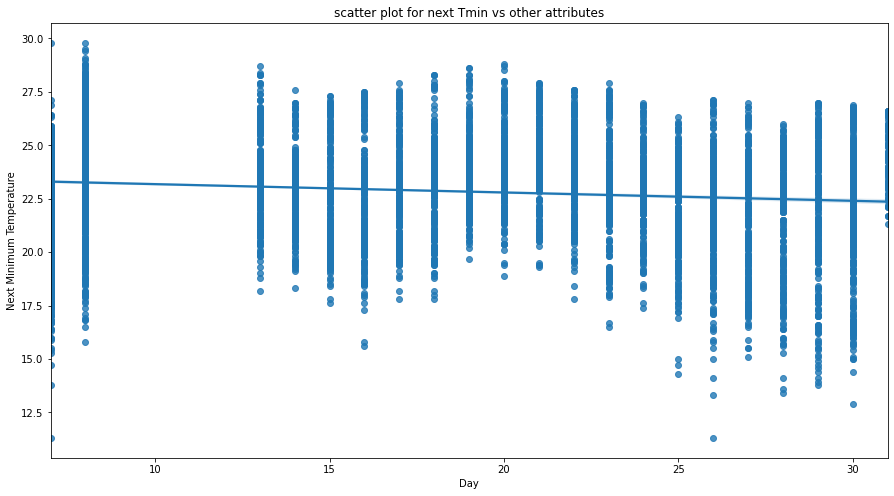

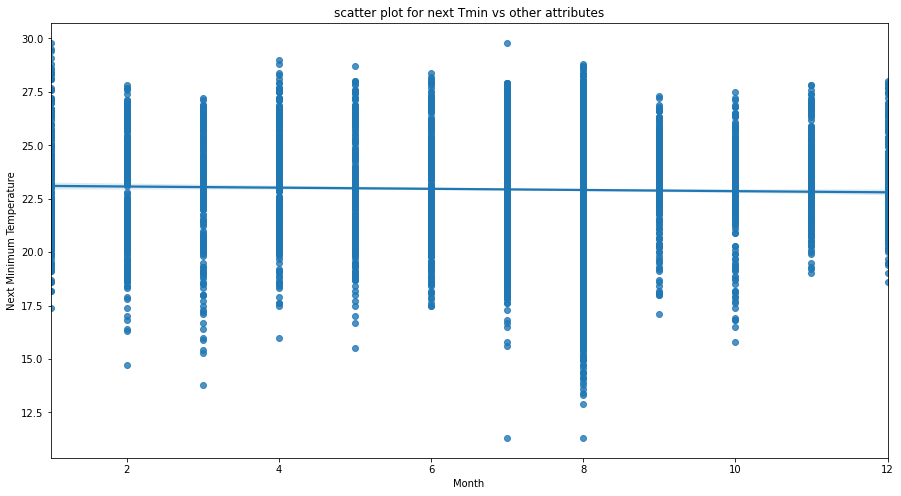

In [25]:
for i in df_new.columns:
    plt.figure(figsize=(15,8))
    sns.regplot(df_new[i],df_new['Next_Tmin'])
    plt.title('scatter plot for next Tmin vs other attributes')
    plt.xlabel(i)
    plt.ylabel('Next Minimum Temperature')
    plt.show()

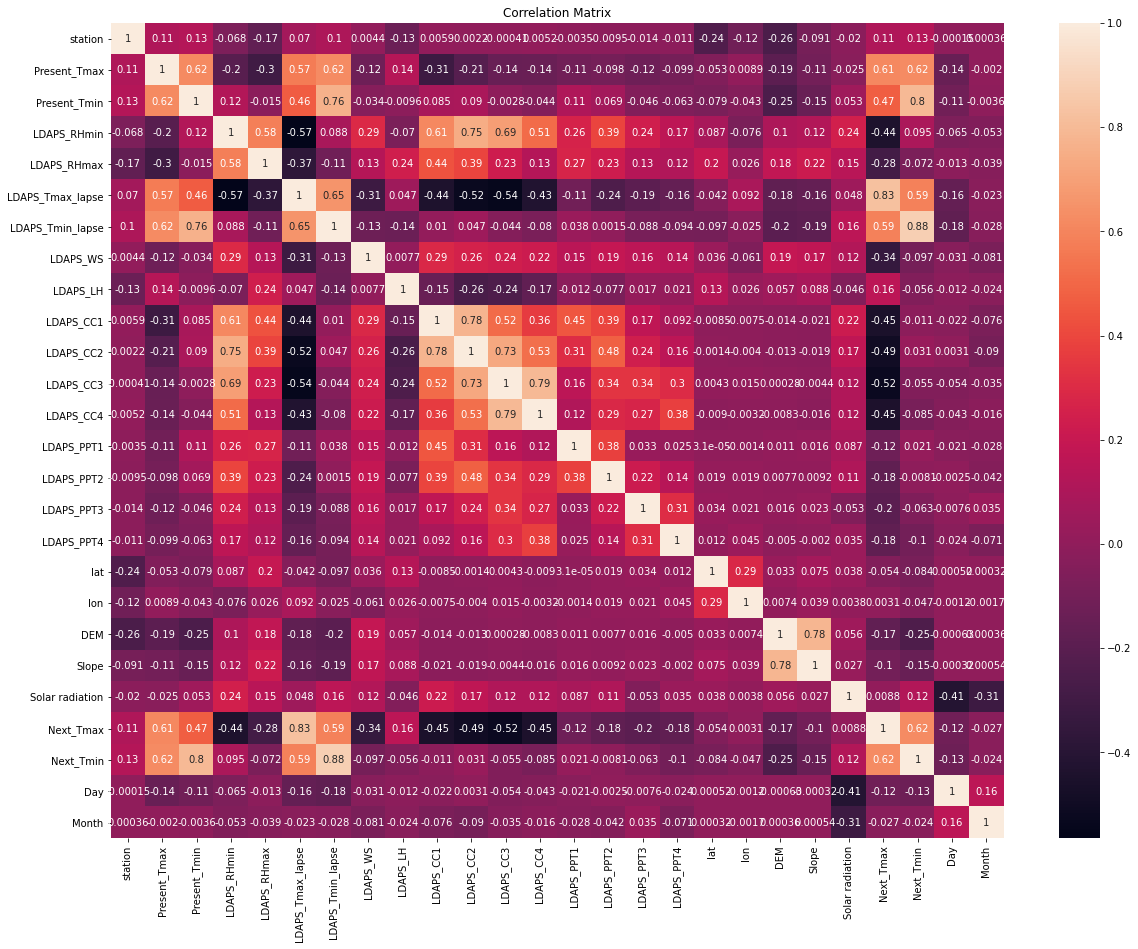

In [26]:
plt.figure(figsize=[20,15])
sns.heatmap(df_new.corr(),annot=True)
plt.title('Correlation Matrix')
plt.show()

In [27]:
plt.figure(figsize=(25,10))
df_new.corr()['Next_Tmax'].sort_values(ascending=False).drop(['Next_Tmax']).plot(kind='bar',color='c')
plt.xlabel('Features')
plt.ylabel('column with target names')
plt.title('Correlation')
plt.show()

In [28]:
plt.figure(figsize=(25,10))
df_new.corr()['Next_Tmin'].sort_values(ascending=False).drop(['Next_Tmin']).plot(kind='bar',color='c')
plt.xlabel('Features')
plt.ylabel('column with target names')
plt.title('Correlation')
plt.show()

# outlier and skewness

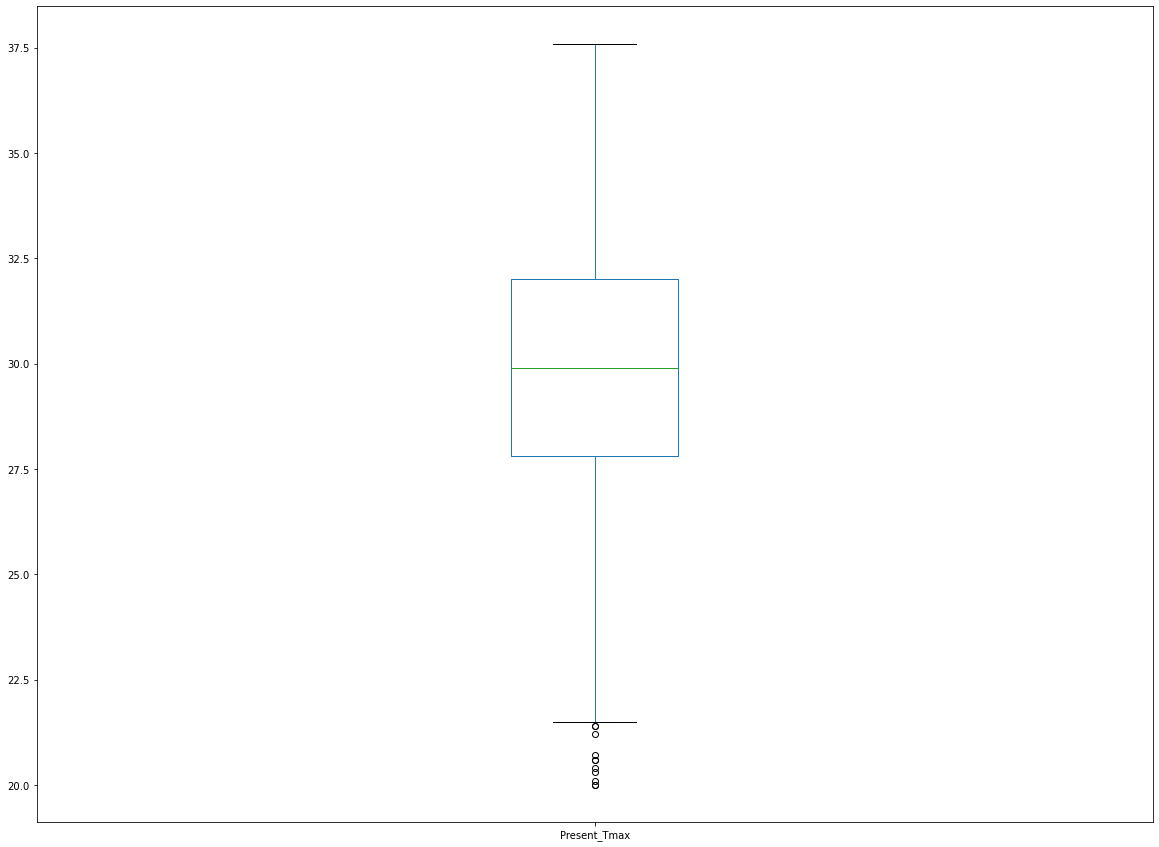

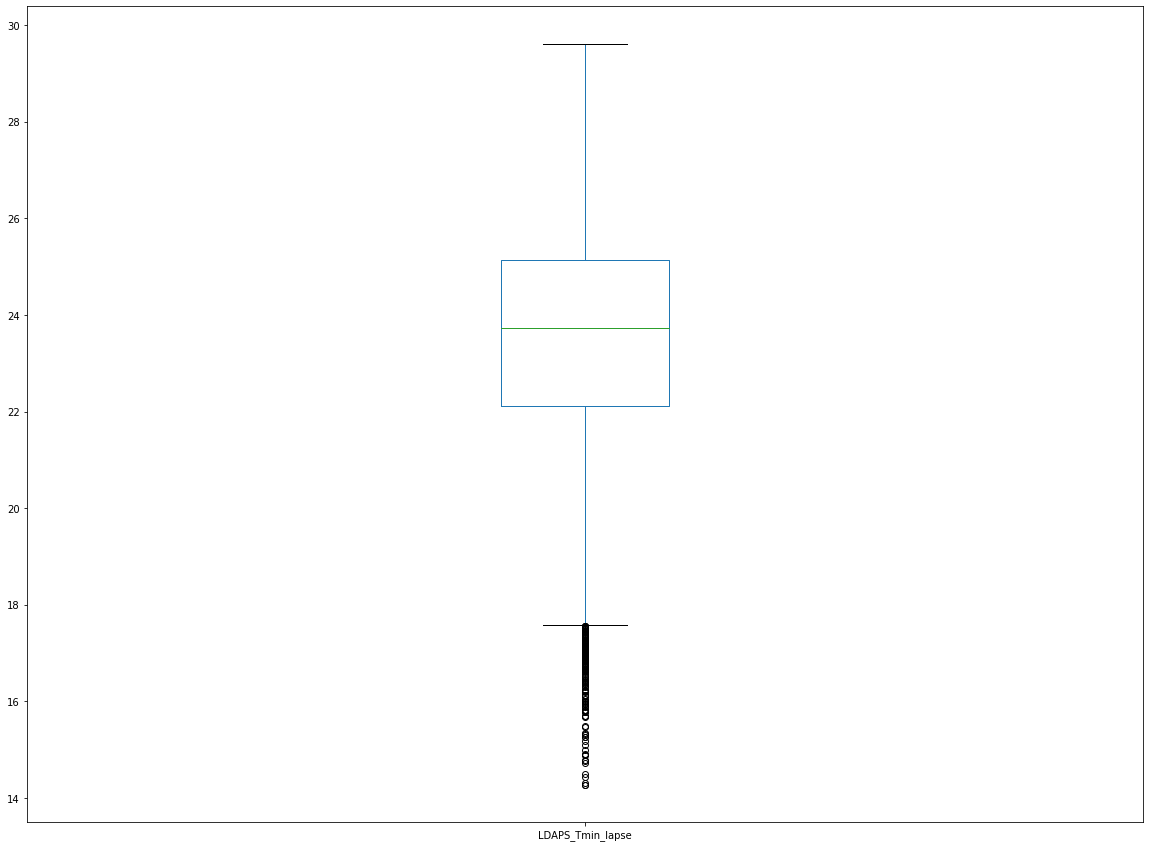

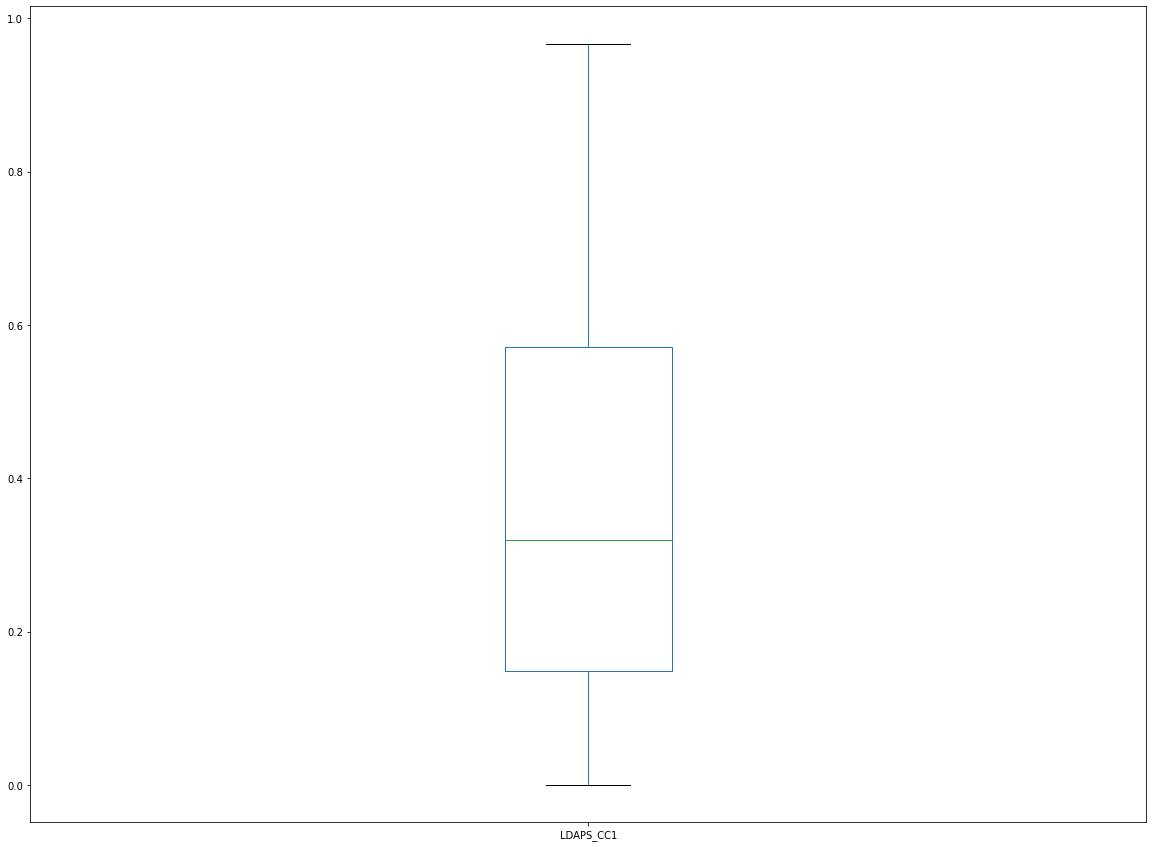

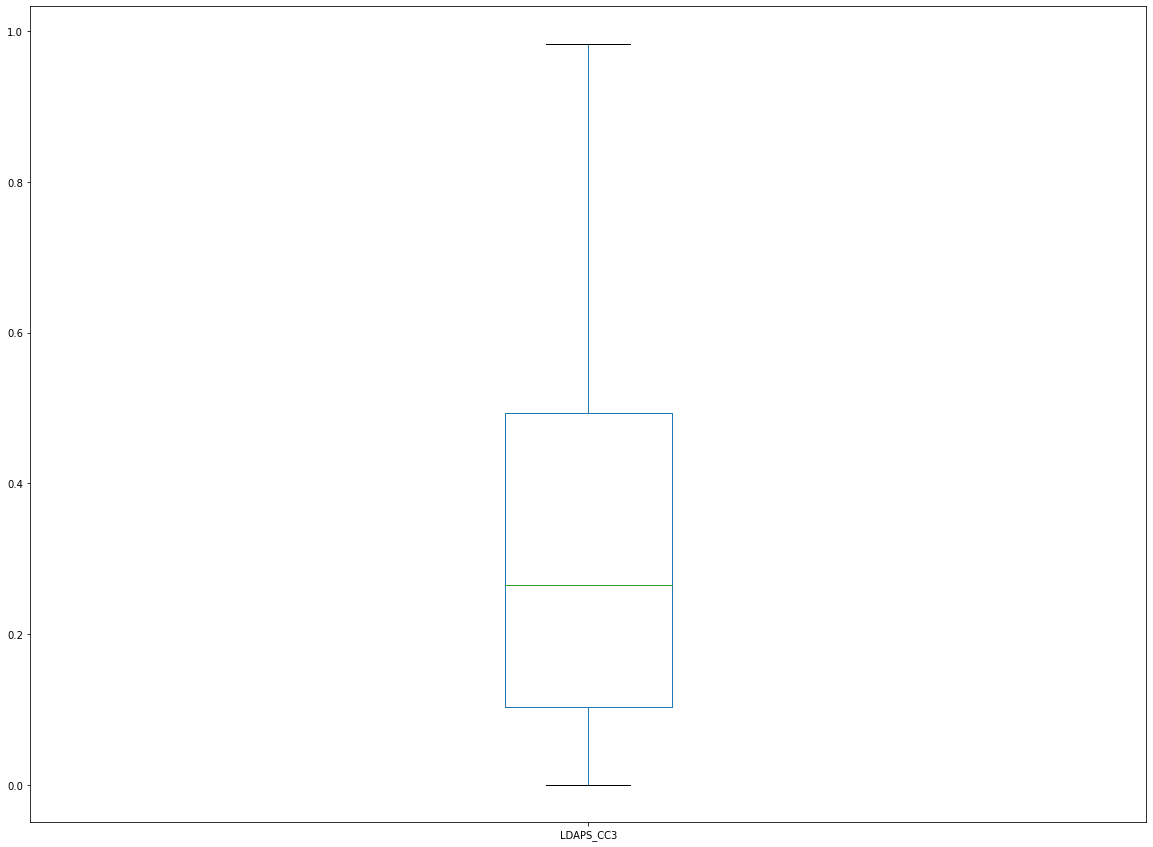

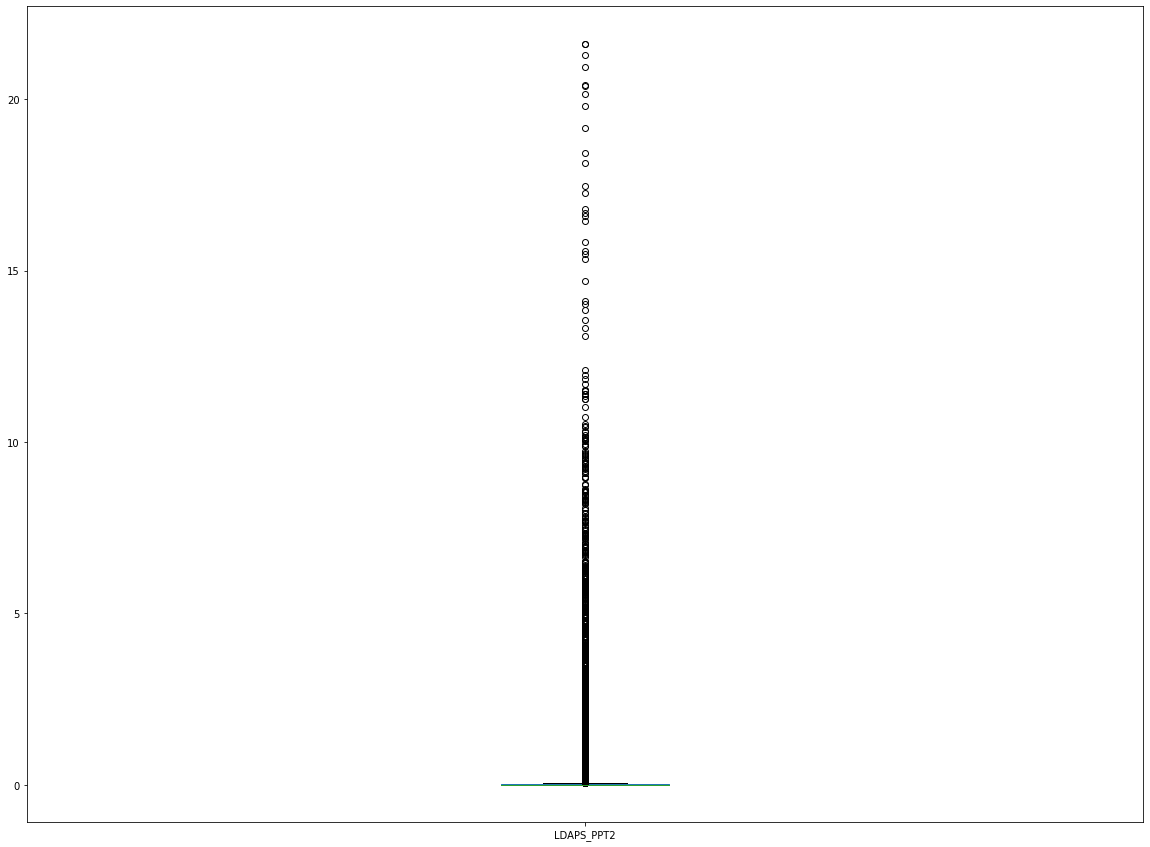

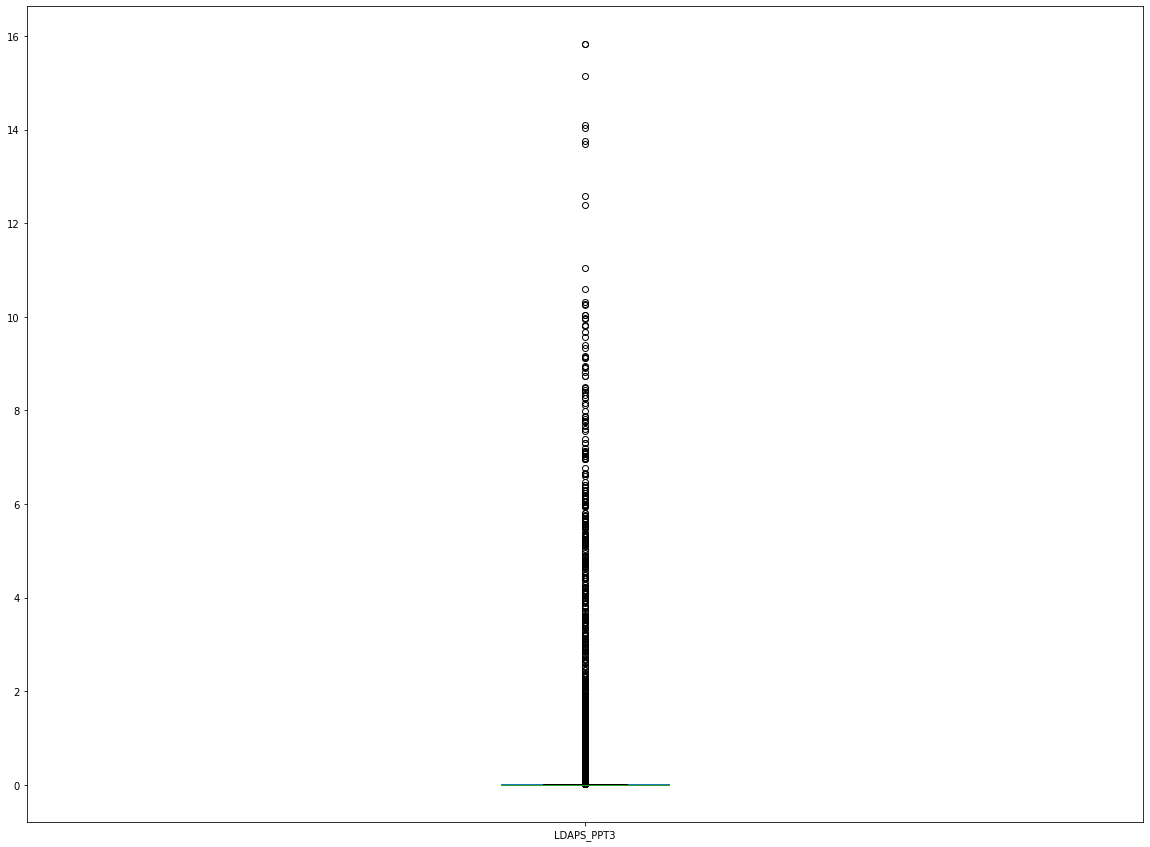

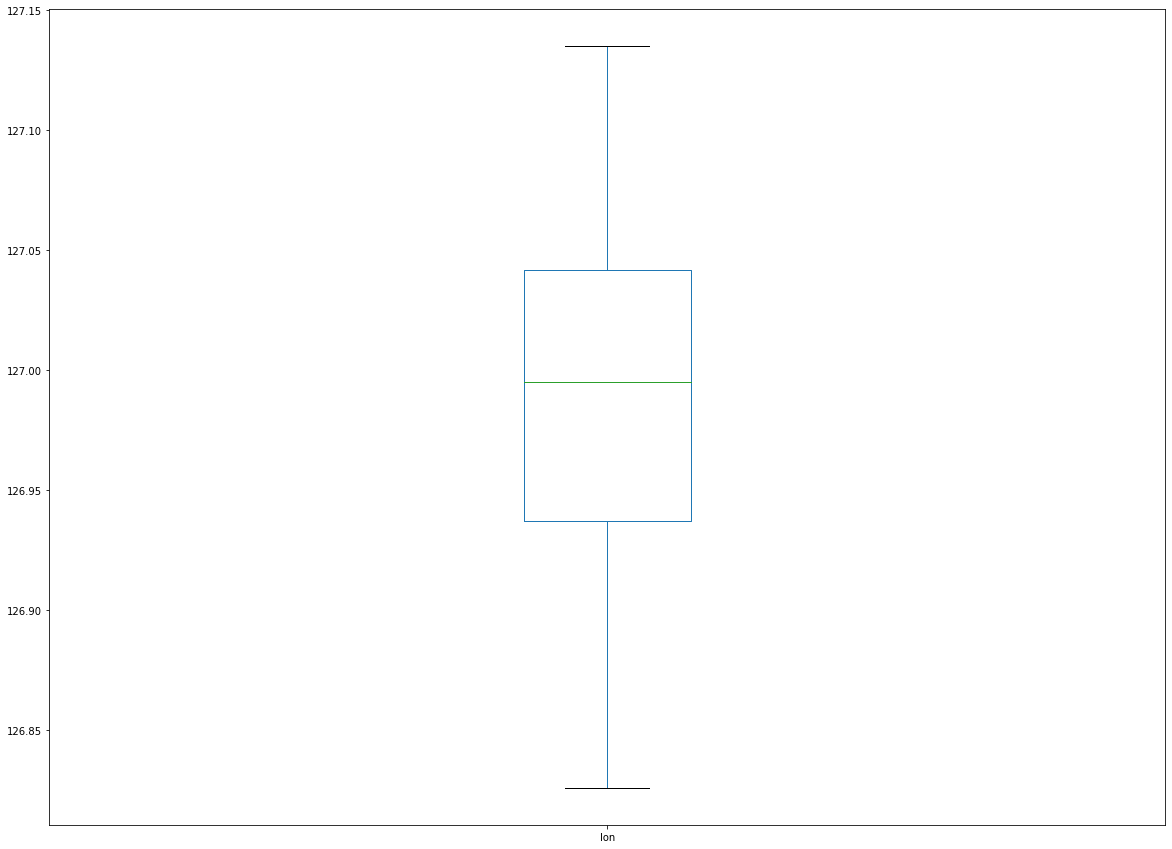

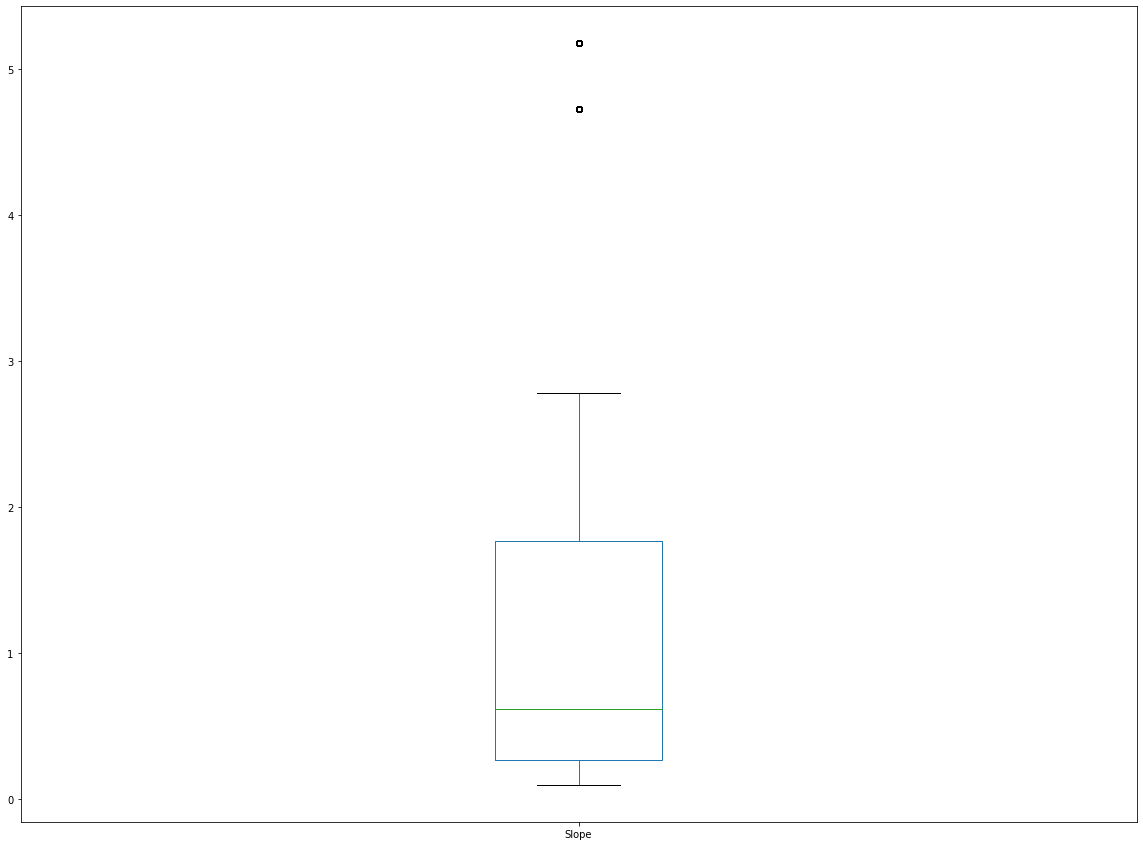

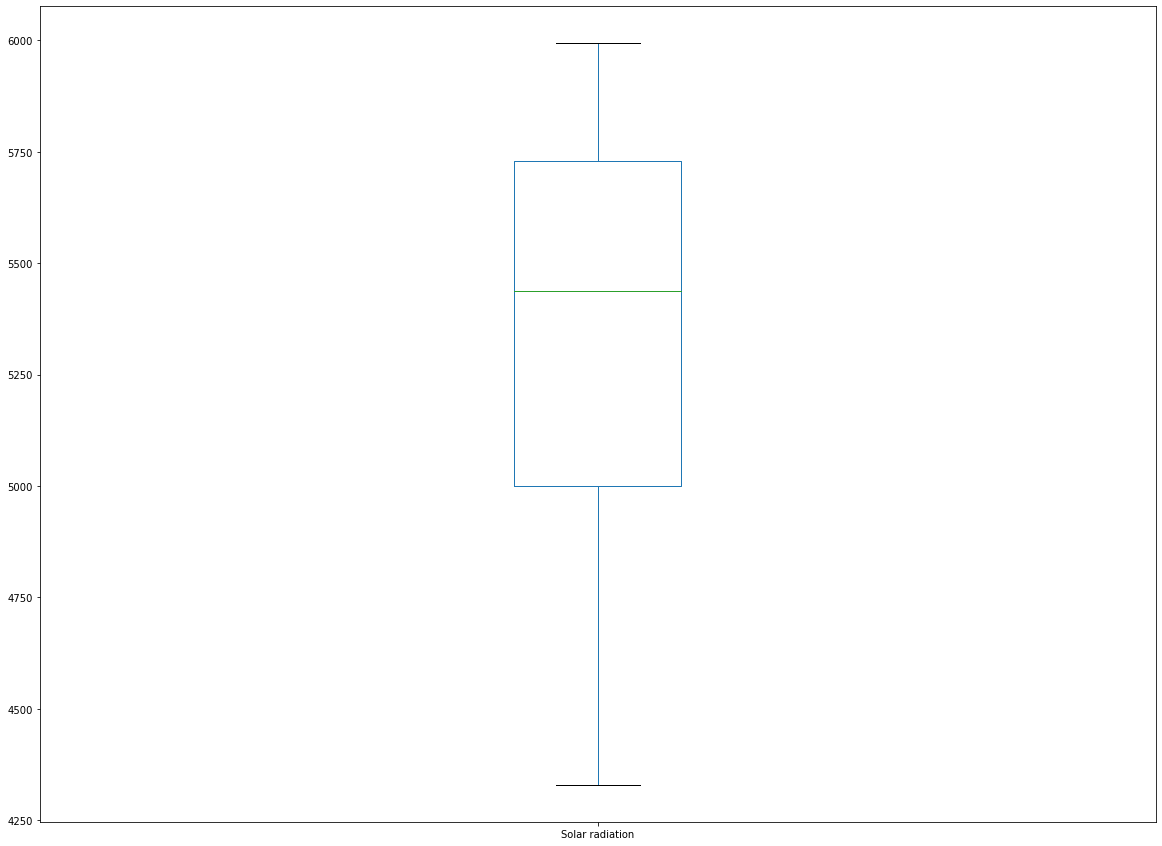

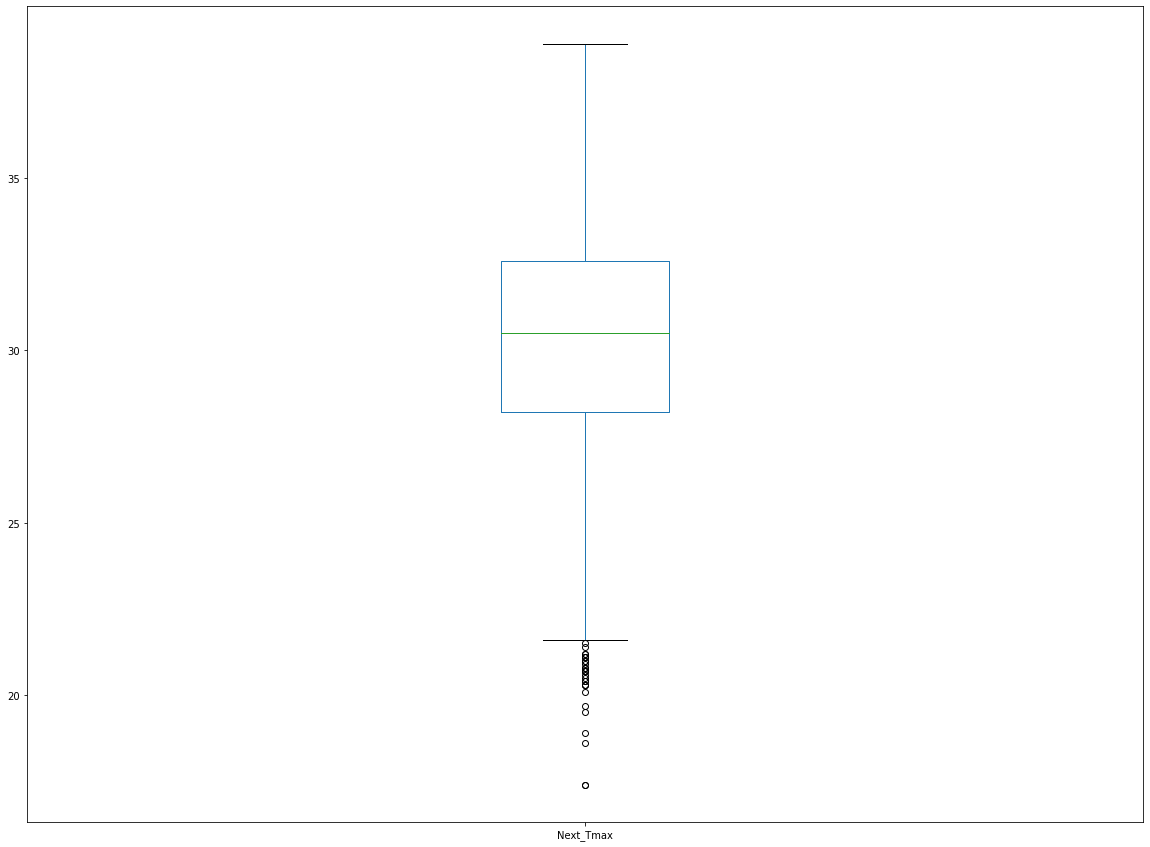

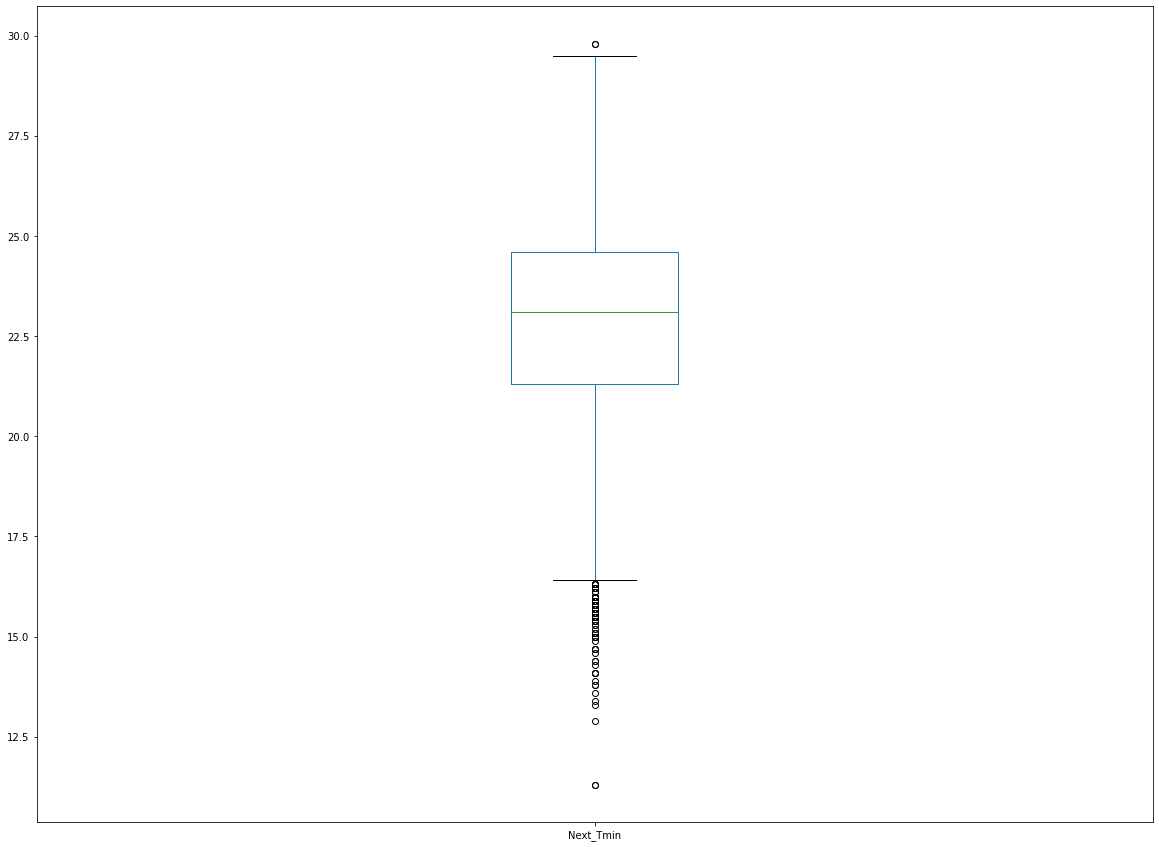

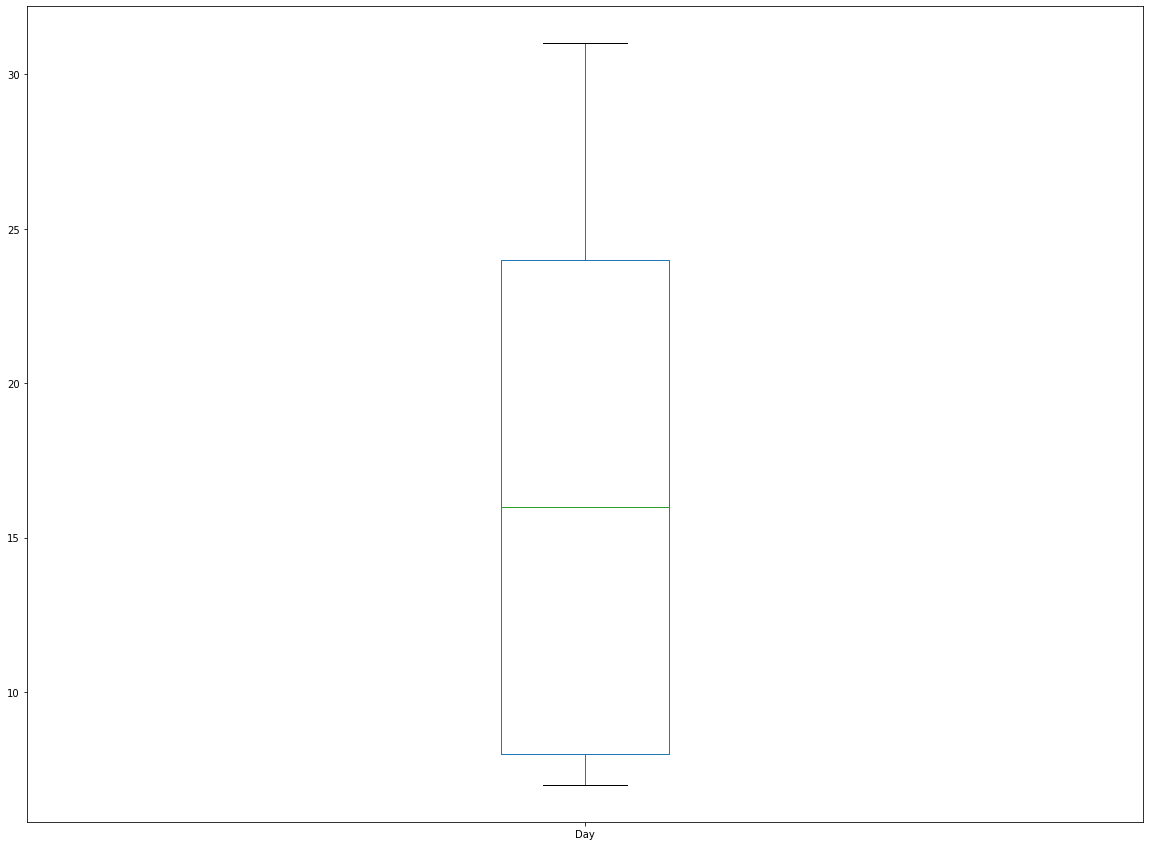

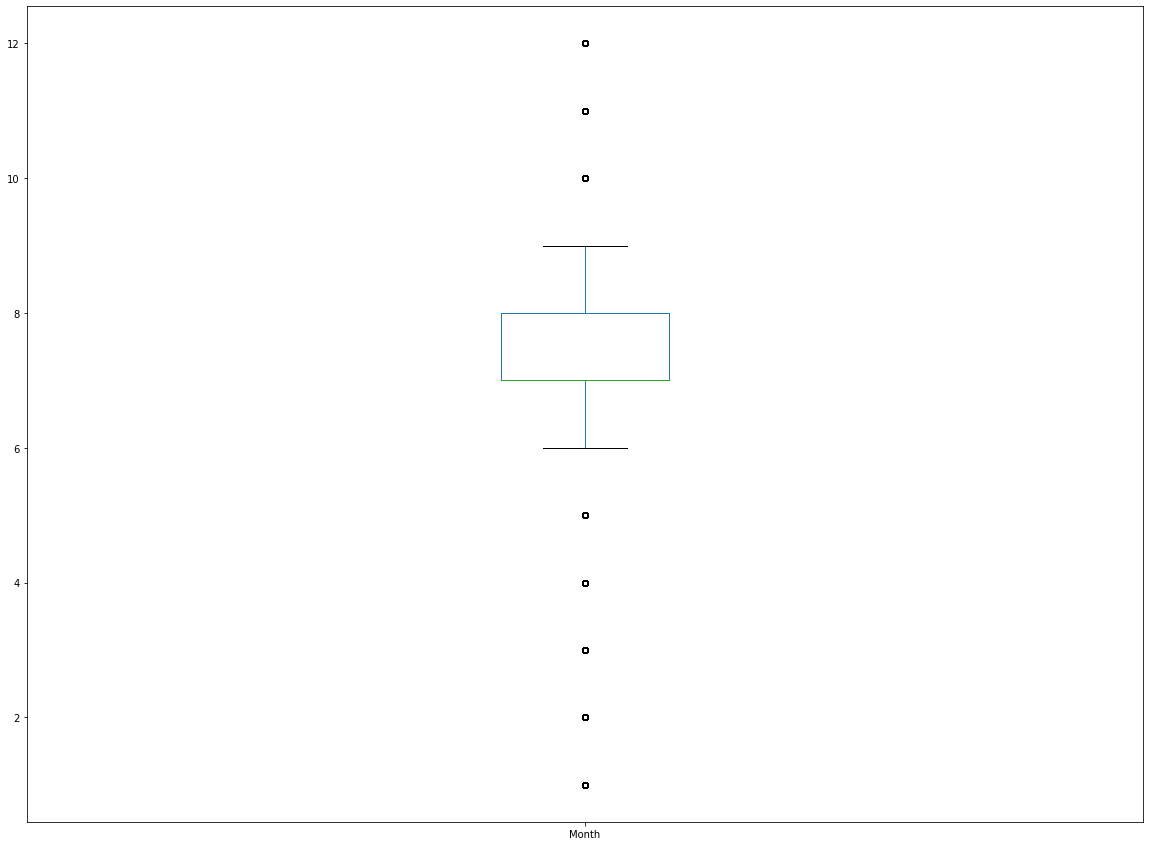

In [29]:
for i in df_new.columns:
    plt.figure(figsize=(20,15))
    df_new[i].plot.box()

there are some outliers present in the data

In [30]:
df_new.skew()

station            -0.002774
Present_Tmax       -0.264760
Present_Tmin       -0.366516
LDAPS_RHmin         0.302995
LDAPS_RHmax        -0.854093
LDAPS_Tmax_lapse   -0.227436
LDAPS_Tmin_lapse   -0.580638
LDAPS_WS            1.581481
LDAPS_LH            0.673051
LDAPS_CC1           0.460584
LDAPS_CC2           0.475248
LDAPS_CC3           0.642254
LDAPS_CC4           0.666292
LDAPS_PPT1          5.399236
LDAPS_PPT2          5.782965
LDAPS_PPT3          6.469486
LDAPS_PPT4          6.833840
lat                 0.086587
lon                -0.286558
DEM                 1.721056
Slope               1.560549
Solar radiation    -0.513787
Next_Tmax          -0.339607
Next_Tmin          -0.403743
Day                 0.245795
Month              -0.704300
dtype: float64

In [31]:
x = df_new.drop(['Next_Tmax', 'Next_Tmin'], axis = 1)
y = df_new.drop(['station', 'Present_Tmax', 'Present_Tmin', 'LDAPS_RHmin', 'LDAPS_RHmax',
       'LDAPS_Tmax_lapse', 'LDAPS_Tmin_lapse', 'LDAPS_WS', 'LDAPS_LH',
       'LDAPS_CC1', 'LDAPS_CC2', 'LDAPS_CC3', 'LDAPS_CC4', 'LDAPS_PPT1',
       'LDAPS_PPT2', 'LDAPS_PPT3', 'LDAPS_PPT4', 'lat', 'lon', 'DEM', 'Slope',
       'Solar radiation', 'Day', 'Month'], axis = 1)

In [32]:
from sklearn.preprocessing import power_transform
df_new=power_transform(x,method='yeo-johnson')
df_new=pd.DataFrame(df_new,columns=x.columns)

In [33]:
x=df_new

In [34]:
from sklearn.preprocessing import StandardScaler

sc=StandardScaler()
x=sc.fit_transform(x)

# Findin best random state

In [35]:
maxr2score=0
maxRS=0

for i in range(1,500):
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.30,random_state=i)
    LR=LinearRegression()
    LR.fit(x_train,y_train)
    predrf=LR.predict(x_test)
    r2=r2_score(y_test,predrf)
    if r2>maxr2score:
        maxr2score=r2
        maxRS=i
        
print('Max R2 Score obtained is',maxr2score,'on random state',maxRS)

Max R2 Score obtained is 0.8085975432465309 on random state 475


In [36]:
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.30,random_state=475)


In [37]:
LR=LinearRegression()
dt=DecisionTreeRegressor()
rf=RandomForestRegressor()

models=[LR,dt,rf]
for i in models:
    print(i)
    i.fit(x_train,y_train)
    pred=i.predict(x_test)
    print(r2_score(y_test,pred))
    print(mean_squared_error(y_test,pred))
    print(mean_squared_error(y_test,pred))

LinearRegression()
0.8085975432465309
1.5934128051508876
1.5934128051508876
DecisionTreeRegressor()
0.7758725265276522
1.8119068162208798
1.8119068162208798
RandomForestRegressor()
0.9035739605955057
0.7741824907247621
0.7741824907247621


In [38]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

In [39]:
for i in models:
    cvs=cross_val_score(i,x,y,cv=cv)
    print('cross validation score for',i,'model is:',cvs.mean())
    print('')

cross validation score for LinearRegression() model is: 0.7925923186421521

cross validation score for DecisionTreeRegressor() model is: 0.781665929311152

cross validation score for RandomForestRegressor() model is: 0.9061280650829533



# hypertunning

In [40]:
from sklearn.model_selection import GridSearchCV

In [41]:
param_grid={
    'n_estimators':[200,500],
    'max_features':['auto','sqrt','log2'],
    'max_depth':[4,5,6,7,8],
    'criterion':['mse','mae']
}

In [ ]:
GCV=GridSearchCV(estimator=rf,param_grid=param_grid,cv=3)
GCV.fit(x_train,y_train)

In [ ]:
GCV.best_params_

In [ ]:
rfr=RandomForestRegressor(random_state=475,max_features='auto',n_estimators=500,max_depth=8,criterion='mse')
rfr.fit(x_train,y_train)
predrfr=rfr.predict(x_test)
print(r2score(y_test,predrfr))
print(mean_squared_error(y_test,predrfr))
print(mean_absolute_error(y_test,predrfr))

In [ ]:
plt.figure(figsize = (20, 15))
plt.scatter(x = y_test, y = predrfr, color = 'r')
plt.plot(y_test, y_test, color = 'b')
plt.xlabel('Actual Value', fontsize = 14)
plt.ylabel('Predicted Value', fontsize = 14)
plt.title('Linear Regression', fontsize = 18)
plt.show()

In [ ]:
import pickle

filename='Temperature.pkl'
pickle.dump(rfr,open(filename,'wb'))

# Conclusion

In [ ]:
loaded_model=pickle.load(opne('Temperature.pkl','rb'))
result=loaded_model.score(x_test,y_test)
print(result)